In [ ]:
!pip install pytorch-lightning==1.5.10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 56.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
arviz 0.15.1 requires setuptools>=60.0.0, but you have setuptools 59.5.0 which is incompatible.
cvxpy 1.3.2 requires setu

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import pytorch_lightning as pl

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
BATCH_SIZE = 128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2)

In [ ]:
class MNISTDataModule(pl.LightningDataModule):
  def __init__ (self, data_dir='./data', batch_size = BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Initializes the MNISTDataModule.

    Args:
        data_dir (str): Directory to store the dataset.
        batch_size (int): Size of the mini-batches during training.
        num_workers (int): Number of workers for DataLoader.
    """
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size
    self.num_workers = num_workers

    self.transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    )

  def prepare_data(self):
    """
    Downloads and prepares the MNIST dataset.
    """
    MNIST(self.data_dir, train=True, download=False)
    MNIST(self.data_dir, train=False, download=True)

  def setup(self, stage=None):
    """
    Splits the dataset into training, validation, and test sets.

    Args:
        stage (str, optional): 'fit' for training/validation, 'test' for testing.
    """
    if stage=="fit" or stage is None:
      mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
      self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

    if stage=="test" or stage is None:
      self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

  def train_dataloader(self):
    """
    Returns DataLoader for the training set.
    """
    return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

  def val_dataloader(self):
    """
    Returns DataLoader for the validation set.
    """
    return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

  def test_dataloader(self):
    """
    Returns DataLoader for the test set.
    """
    return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [ ]:
# Define the Discriminator neural network class
class Discriminator(nn.Module):
  def __init__(self):
    """
    Initializes the Discriminator neural network.

    The architecture consists of convolutional layers, max-pooling, dropout, and fully connected layers.

    Input: 1 channel (grayscale image)
    Output: 1 (sigmoid activation for binary classification)
    """
    super().__init__()

    # First convolutional layer with 5x5 kernel, input channels=1, output channels=10
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)

    # Second convolutional layer with 5x5 kernel, input channels=10, output channels=20
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

    # Dropout layer to prevent overfitting
    self.conv2d_drop = nn.Dropout2d()

    # Fully connected layers
    self.fc1 = nn.Linear(320, 50)     # 320 input features, 50 output features
    self.fc2 = nn.Linear(50, 1)       # 50 input features, 1 output feature

  def forward(self, x):
    """
    Defines the forward pass of the Discriminator.

    Args:
        x (torch.Tensor): Input tensor.

    Returns:
        torch.Tensor: Output tensor with sigmoid activation for binary classification.
    """

    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2d_drop(self.conv2(x)), 2))

    # Reshape the tensor for the fully connected layers
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)

    # Final fully connected layer with sigmoid activation for binary classification
    x = self.fc2(x)
    return torch.sigmoid(x)

In [ ]:
# Define the Generator neural network class
class Generator(nn.Module):
  def __init__(self, latent_dim):
    """
    Initializes the Generator neural network.

    The architecture consists of linear and transpose convolutional layers to generate images.

    Args:
        latent_dim (int): Dimensionality of the latent space.
    """
    super().__init__()

    # Linear layer to transform the latent space to the initial convolutional shape
    self.lin1 = nn.Linear(latent_dim, 7*7*64)

    # Transpose convolutional layers to upsample the data
    self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)
    self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)

    # Final convolutional layer to generate the output image
    self.conv = nn.Conv2d(16, 1, kernel_size=7)

  def forward(self, x):
    """
    Defines the forward pass of the Generator.

    Args:
        x (torch.Tensor): Input tensor from the latent space.

    Returns:
        torch.Tensor: Output tensor representing the generated image.
    """
    # Linear layer to transform the input from latent space to initial convolutional shape
    x = self.lin1(x)
    x = F.relu(x)

    # Reshape the tensor for the transpose convolutional layers
    x = x.view(-1, 64, 7, 7)

    x = self.ct1(x)
    x = F.relu(x)

    x = self.ct2(x)
    x = F.relu(x)

    # Final convolutional layer to generate the output image
    return self.conv(x)

In [ ]:
# Define the GAN LightningModule class
class GAN(pl.LightningModule):

  def __init__(self, latent_dim=100, lr=0.0002):
    """
    Initializes the GAN LightningModule.

    Args:
        latent_dim (int): Dimensionality of the latent space.
        lr (float): Learning rate for optimization.
    """
    super().__init__()
    self.save_hyperparameters()

    self.generator = Generator(latent_dim=self.hparams.latent_dim)
    self.discriminator = Discriminator()

    # Pre-generate random noise for validation
    self.validation_z = torch.randn(6, self.hparams.latent_dim)

  def forward(self, z):
    """
    Defines the forward pass of the GAN.

    Args:
        z (torch.Tensor): Input tensor from the latent space.

    Returns:
        torch.Tensor: Output tensor representing the generated image.
    """
    return self.generator(z)

  def adversarial_loss(self, y_hat, y):
    """
    Computes the adversarial loss using binary cross-entropy.

    Args:
        y_hat (torch.Tensor): Predictions.
        y (torch.Tensor): Ground truth labels.

    Returns:
        torch.Tensor: Adversarial loss.
    """
    return F.binary_cross_entropy(y_hat, y)

  def training_step(self, batch, batch_idx, optimizer_idx):
    """
    Defines the training step for both the Generator and the Discriminator.

    Args:
        batch: Batch of real images.
        batch_idx: Index of the current batch.
        optimizer_idx: Index of the optimizer being used (0 for Generator, 1 for Discriminator).

    Returns:
        dict: Dictionary containing the loss and logging information.
    """

    # Getting real images from the batch
    real_imgs, _ = batch

    # Creating random noise
    z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
    z = z.type_as(real_imgs)

    # For Generator
    if optimizer_idx == 0:

      # The forward step - which creates images using generator from random noise
      fake_imgs = self(z)

      # The output from the discriminator
      # 1 means the discriminator predicted this as a real image, meaning the generator did a great job
      # 0 means the discriminator predicted this as a fake image. The generator needs to improve
      y_hat = self.discriminator(fake_imgs)
      y = torch.ones(real_imgs.size(0), 1)

      y = y.type_as(real_imgs)

      g_loss = self.adversarial_loss(y_hat, y)

      log_dict = {"g_loss": g_loss}

      return {"loss": g_loss, "progress_bar": log_dict, "log": log_dict}

    # For Discriminator
    if optimizer_idx == 1:
      y_hat_real = self.discriminator(real_imgs)

      y_real = torch.ones(real_imgs.size(0), 1)
      y_real = y_real.type_as(real_imgs)

      real_loss = self.adversarial_loss(y_hat_real, y_real)

      y_hat_fake = self.discriminator(self(z).detach())
      y_fake = torch.zeros(real_imgs.size(0), 1)
      y_fake = y_fake.type_as(real_imgs)

      fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

      d_loss = (real_loss + fake_loss) / 2
      log_dict = {"d_loss": d_loss}

      return {"loss": d_loss, "progress_bar": log_dict, "log": log_dict}


  def configure_optimizers(self):
    """
    Configures the optimizers for the Generator and Discriminator.

    Returns:
        list: List of optimizers.
    """
    lr = self.hparams.lr
    opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
    opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
    return [opt_g, opt_d], []

  def plot_imgs(self):
    """
    Plots generated images using the current Generator state.
    """
    z = self.validation_z.type_as(self.generator.lin1.weight)
    sample_imgs = self(z).cpu()

    print('epoch ', self.current_epoch)
    fig = plt.figure()

    for i in range(sample_imgs.size(0)):
      plt.subplot(2, 3, i + 1)
      plt.tight_layout()
      plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap = 'gray_r', interpolation = 'none')
      plt.title("Generated Data")
      plt.xticks([])
      plt.yticks([])
      plt.axis('off')
    plt.show()

  def on_epoch_end(self):
    """
    Hook function called at the end of each epoch.
    """
    self.plot_imgs()


In [ ]:
dm = MNISTDataModule()
# model = GAN()

epoch  0


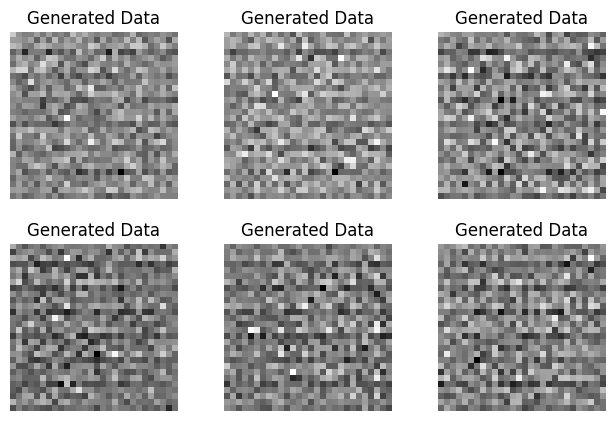

In [ ]:
# model.plot_imgs()

INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/optimization/closure.py:35: LightningDeprecationWarning: One of the returned values {'progress_bar', 'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprecation(


epoch  0


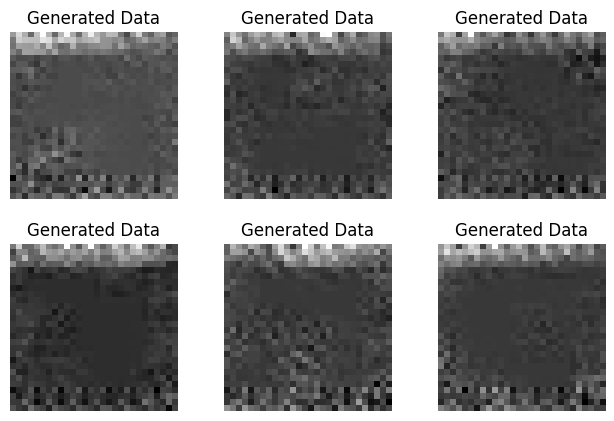

epoch  1


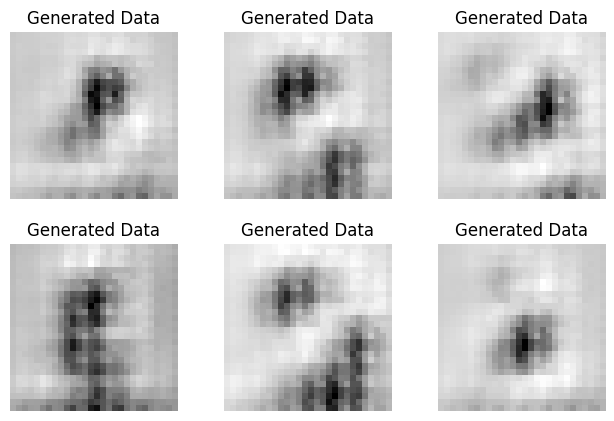

epoch  2


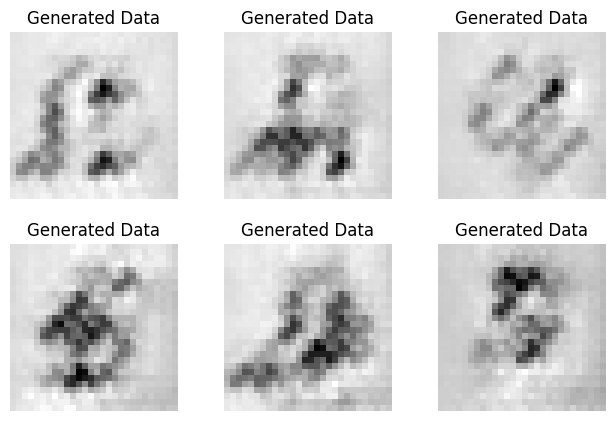

epoch  3


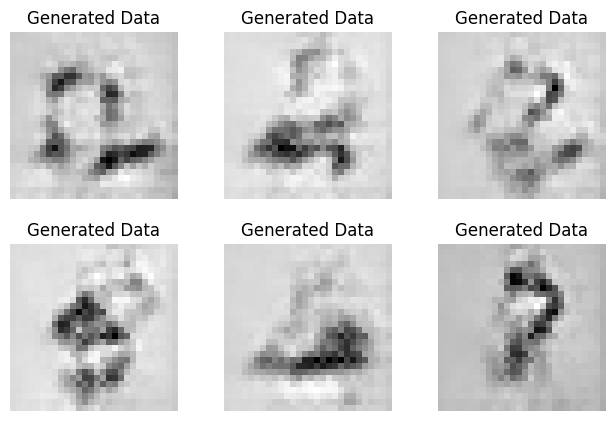

epoch  4


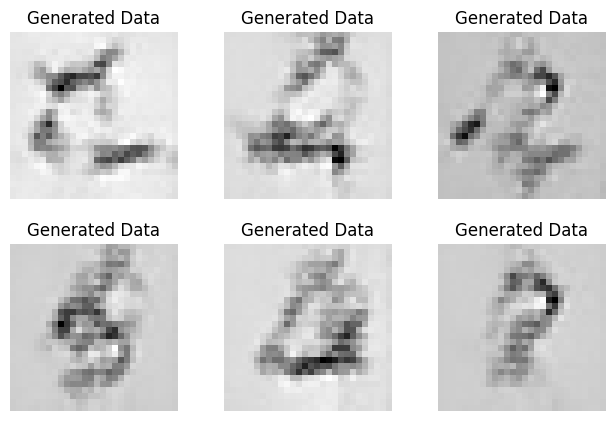

epoch  5


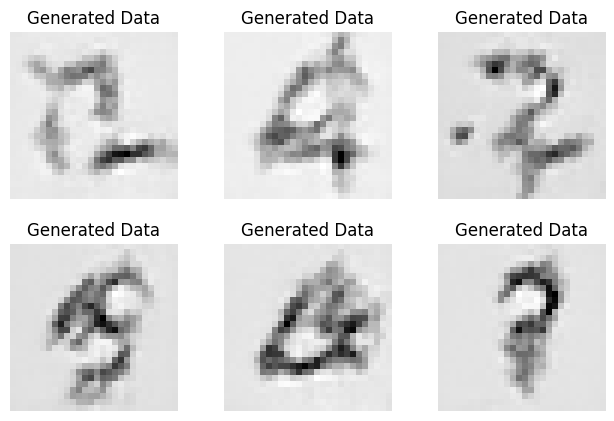

epoch  6


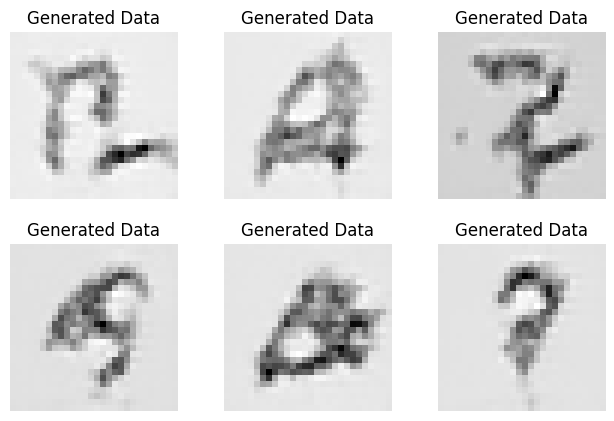

epoch  7


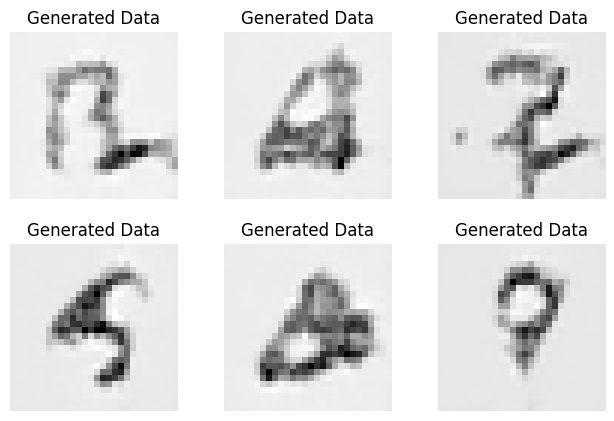

epoch  8


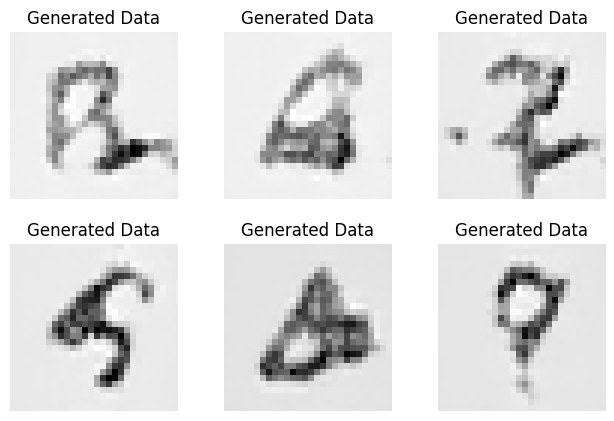

epoch  9


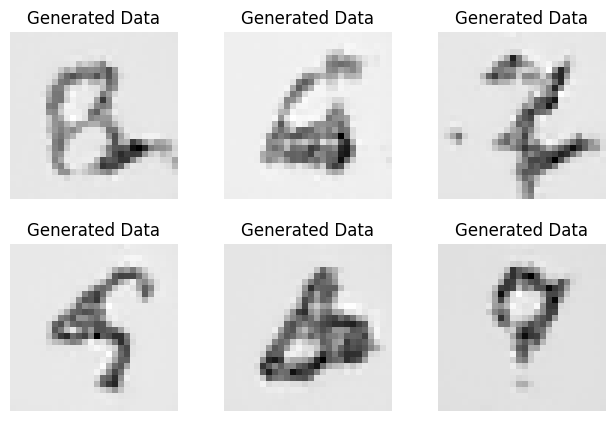

epoch  10


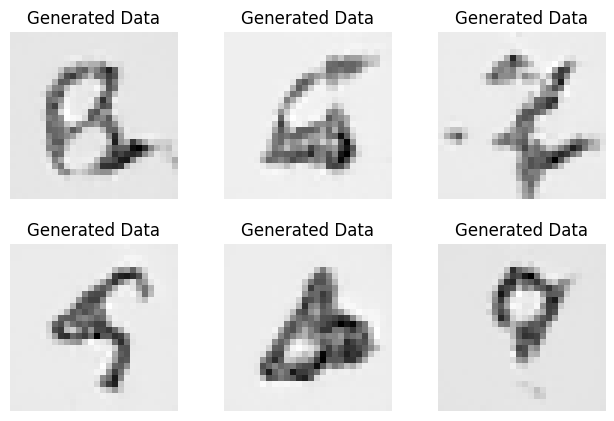

epoch  11


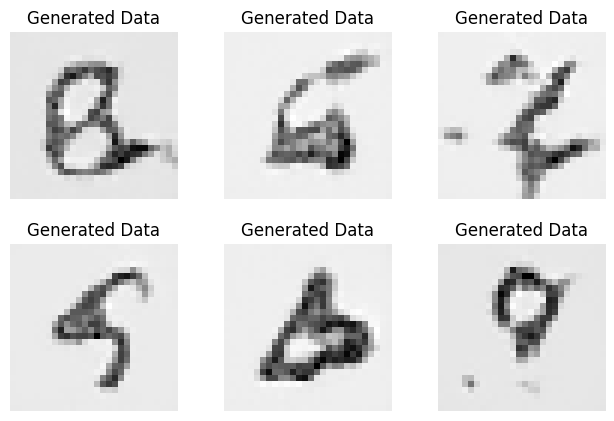

epoch  12


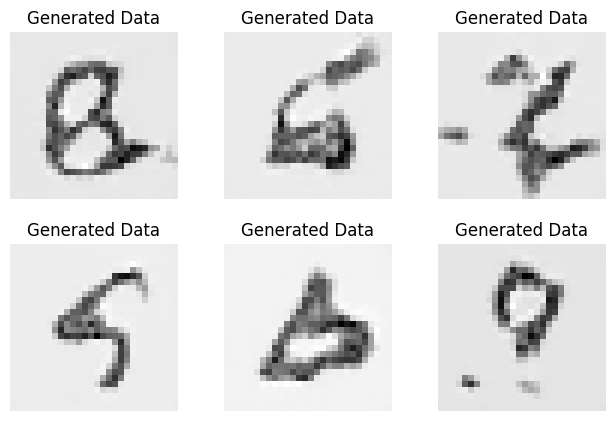

epoch  13


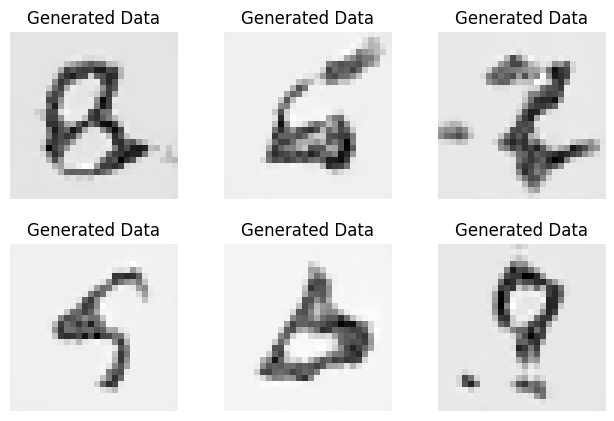

epoch  14


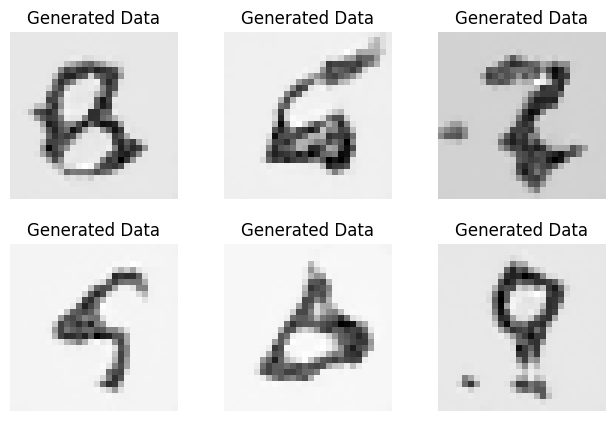

epoch  15


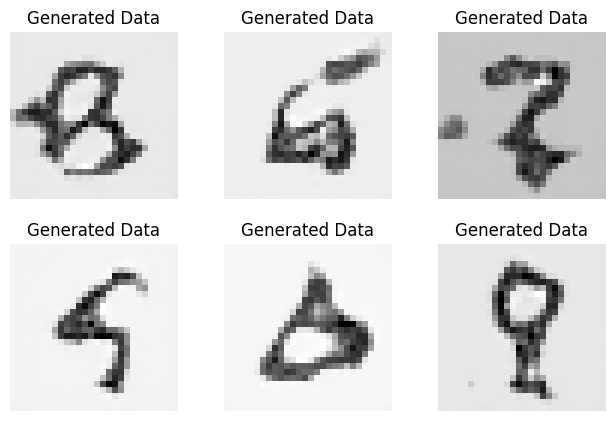

epoch  16


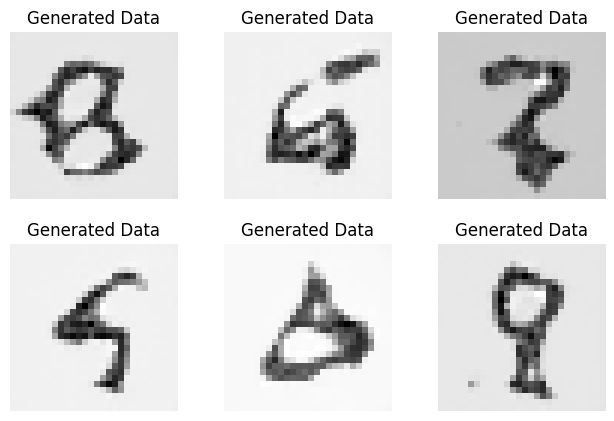

epoch  17


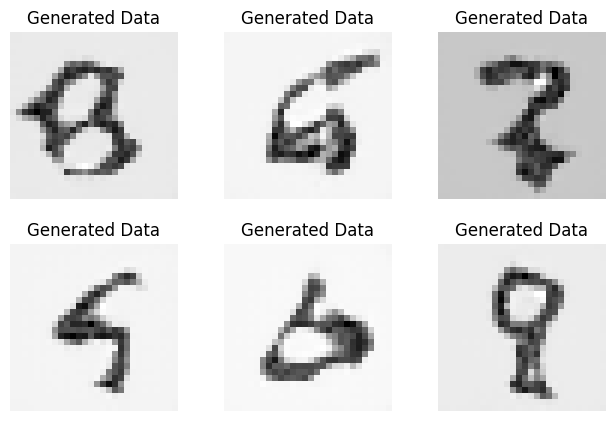

epoch  18


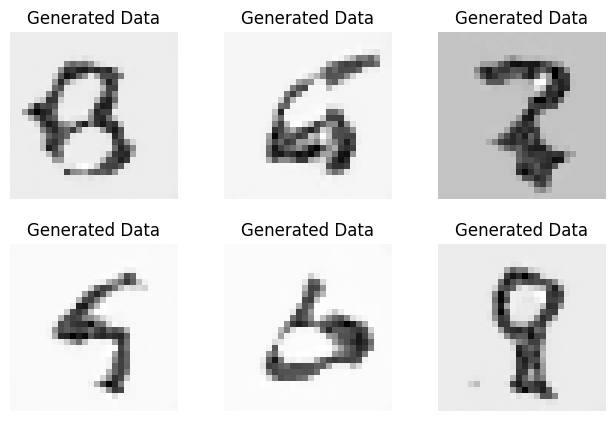

epoch  19


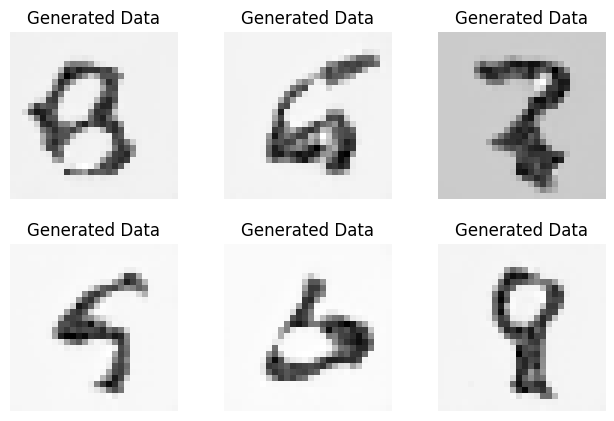

In [ ]:
# trainer = pl.Trainer(max_epochs= 20, gpus= AVAIL_GPUS)
# # trainer = pl.Trainer(max_epochs=20)
# trainer.fit(model, dm)

# Training Post Initial Round of Training

In [ ]:
# trainer.save_checkpoint("/content/drive/MyDrive/Saved_Models/GAN/GAN1.ckpt")
model2 = GAN.load_from_checkpoint(checkpoint_path="/content/drive/MyDrive/Saved_Models/GAN/GAN1.ckpt")

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

epoch  0


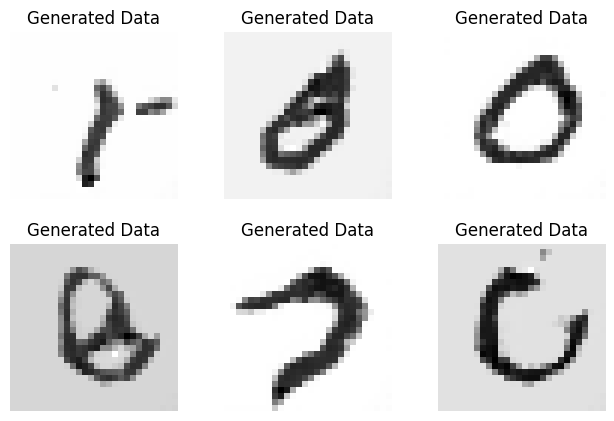

epoch  1


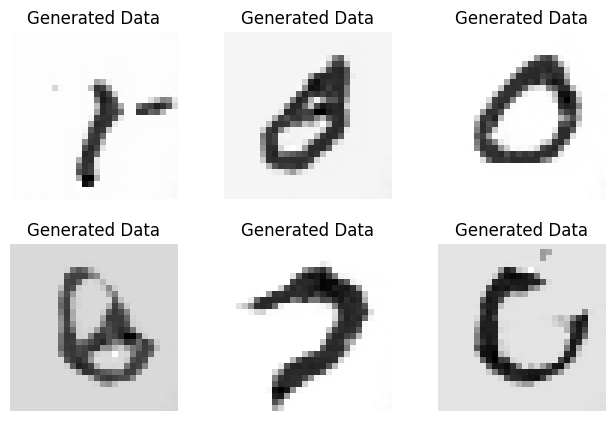

epoch  2


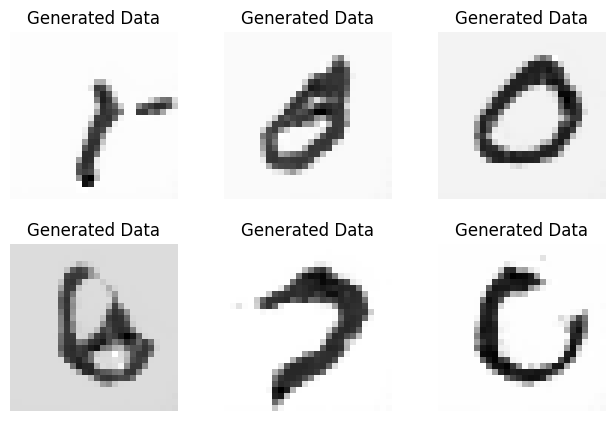

epoch  3


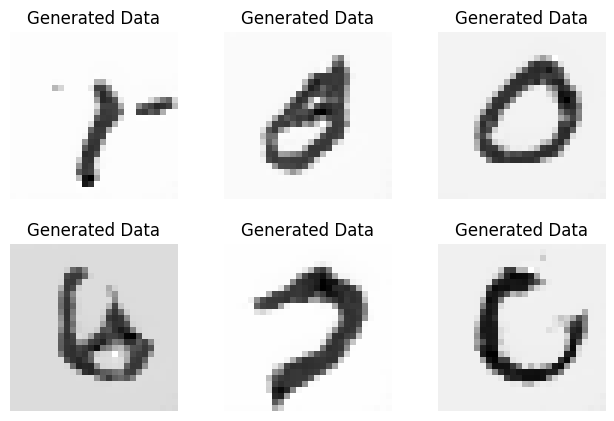

epoch  4


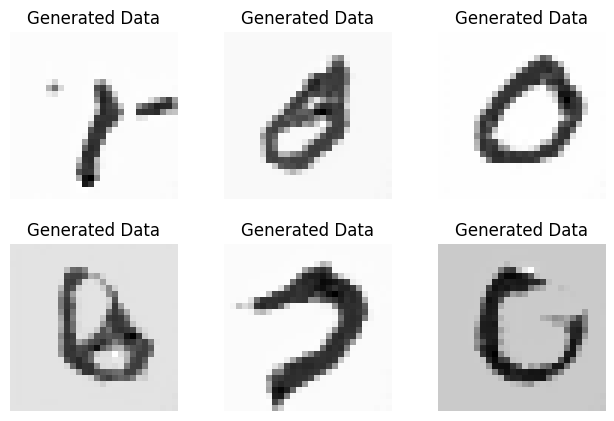

epoch  5


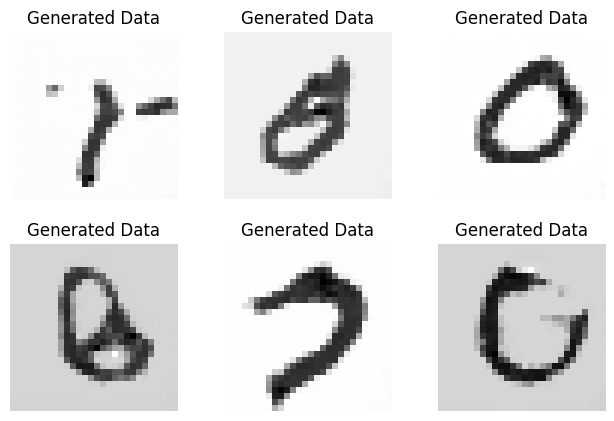

epoch  6


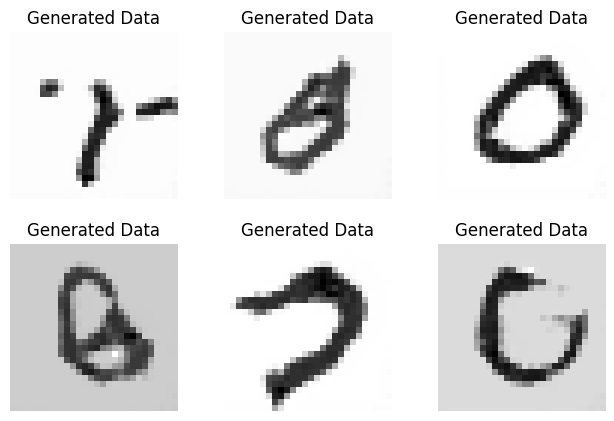

epoch  7


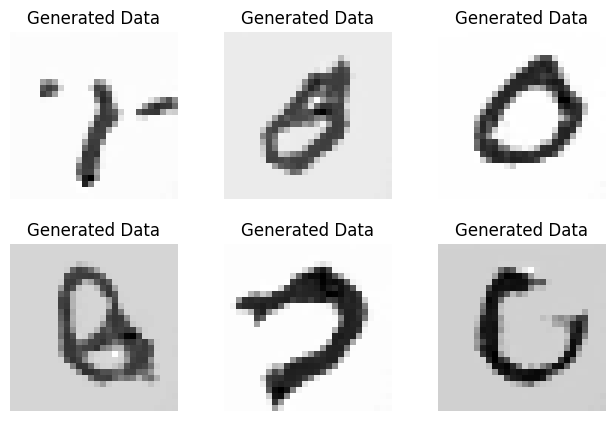

epoch  8


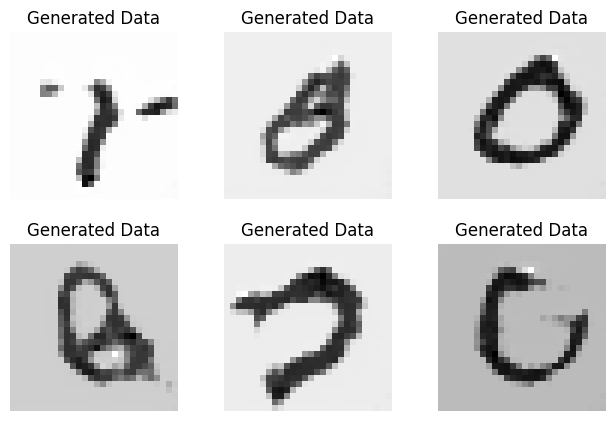

epoch  9


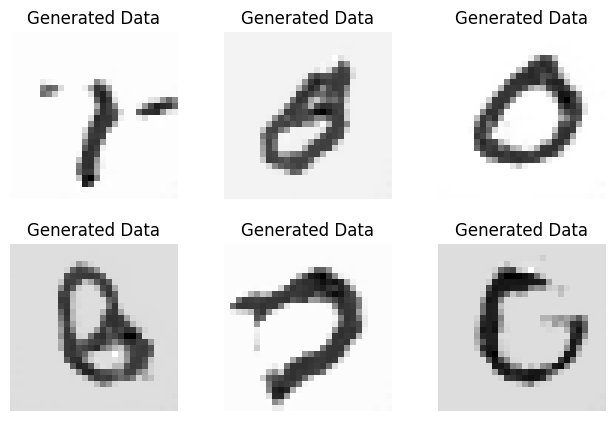

epoch  10


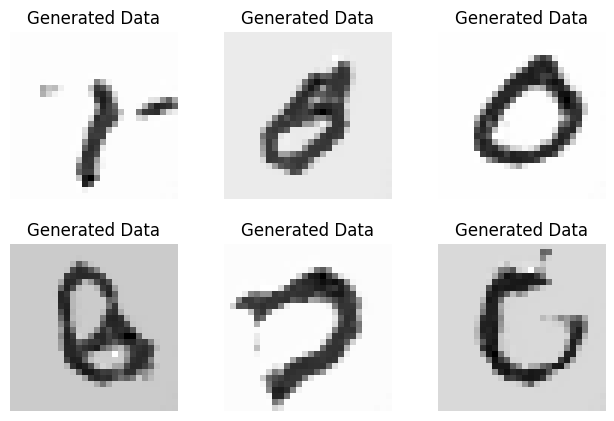

epoch  11


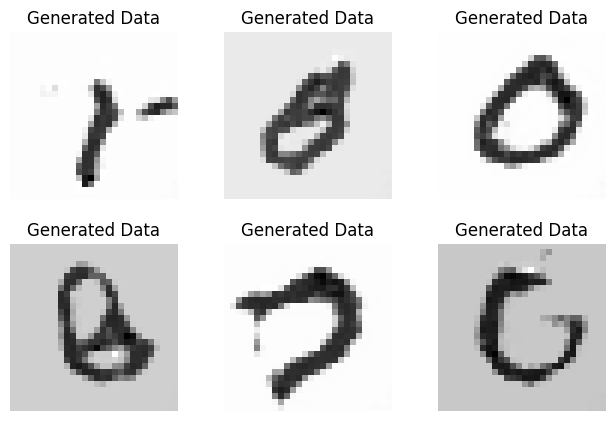

epoch  12


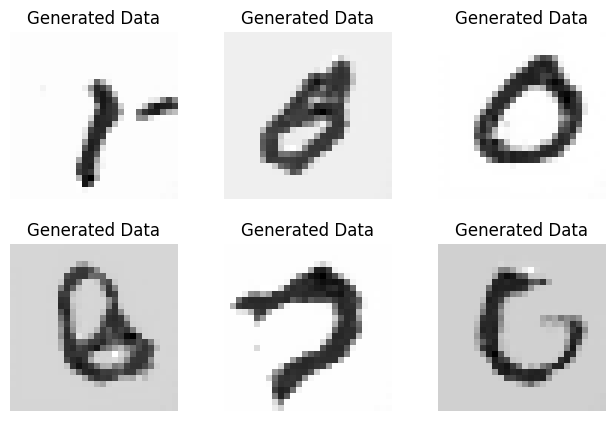

epoch  13


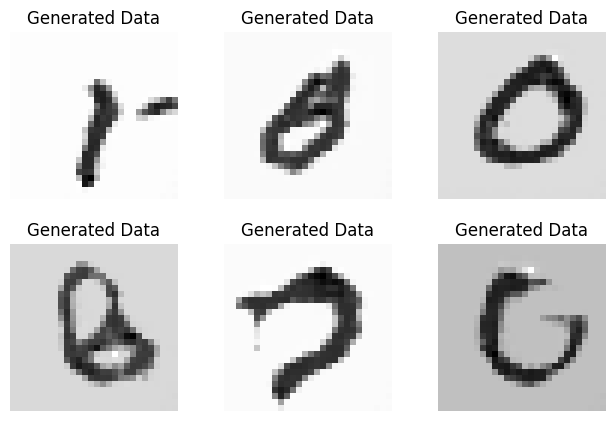

epoch  14


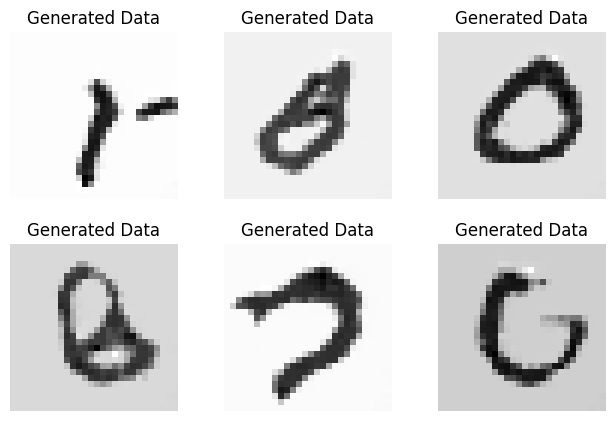

epoch  15


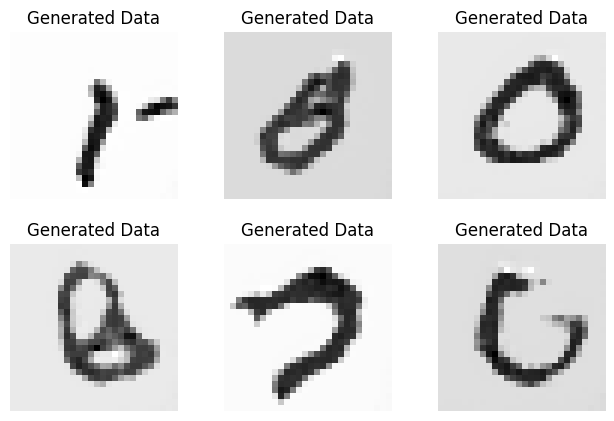

epoch  16


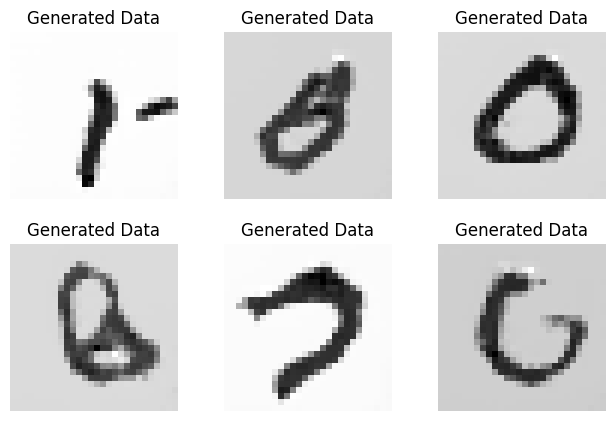

epoch  17


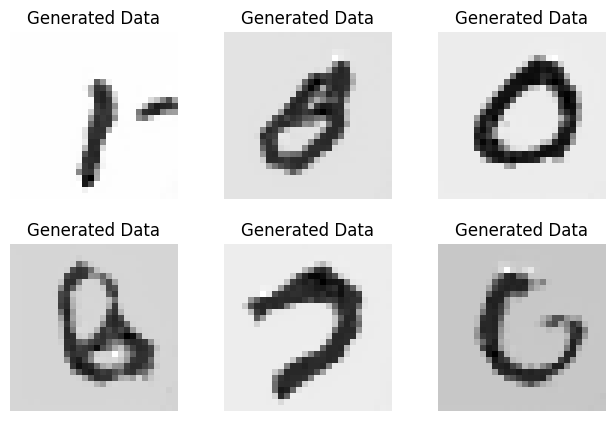

epoch  18


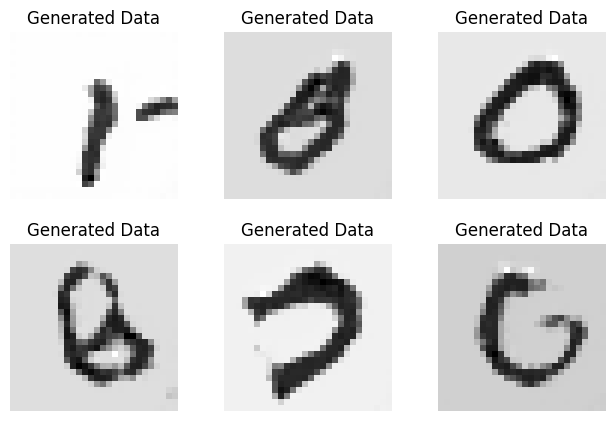

epoch  19


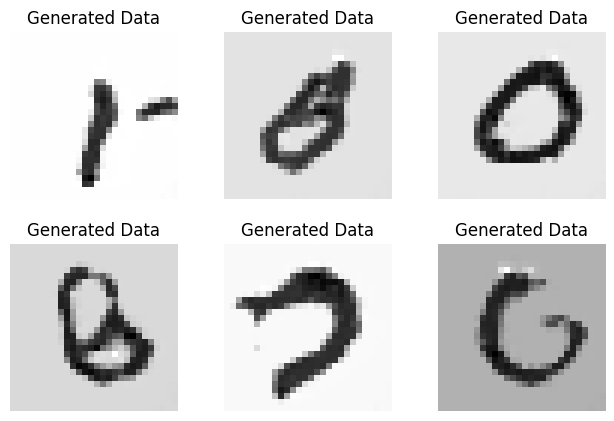

epoch  20


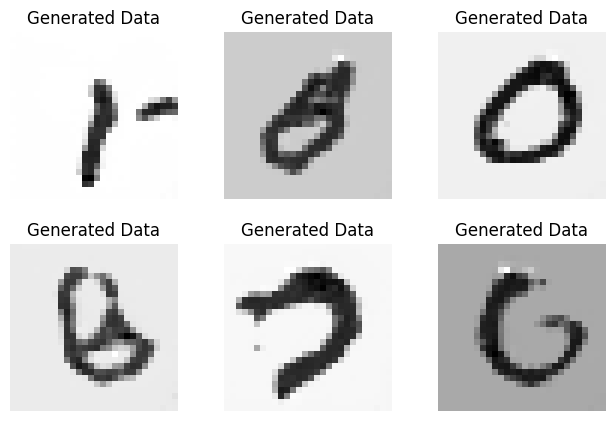

epoch  21


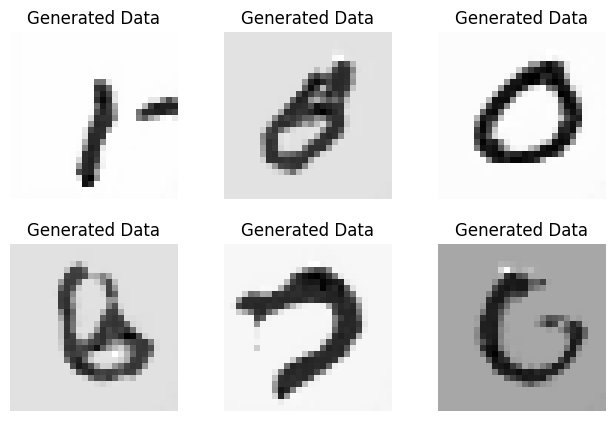

epoch  22


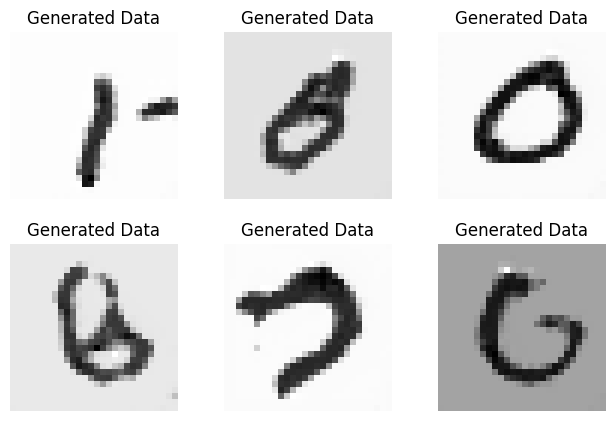

epoch  23


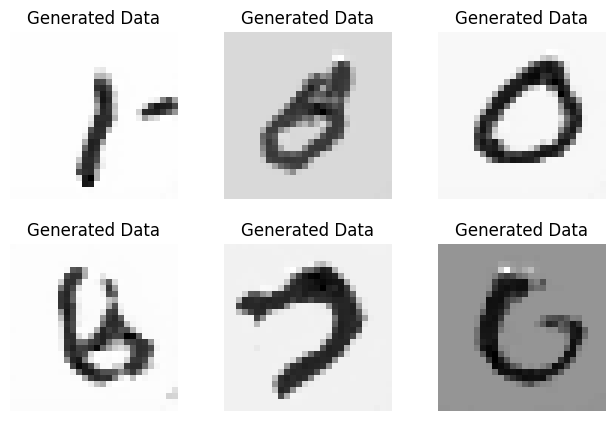

epoch  24


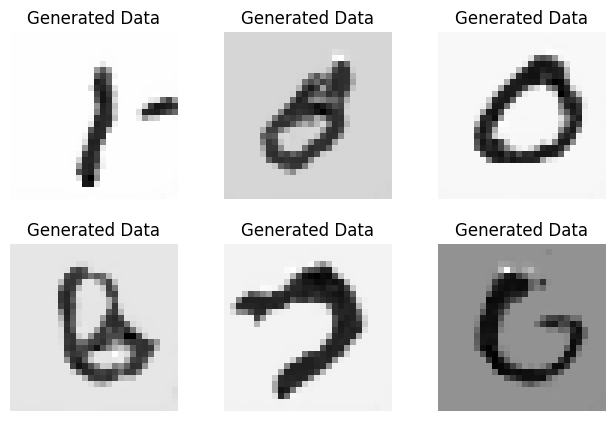

epoch  25


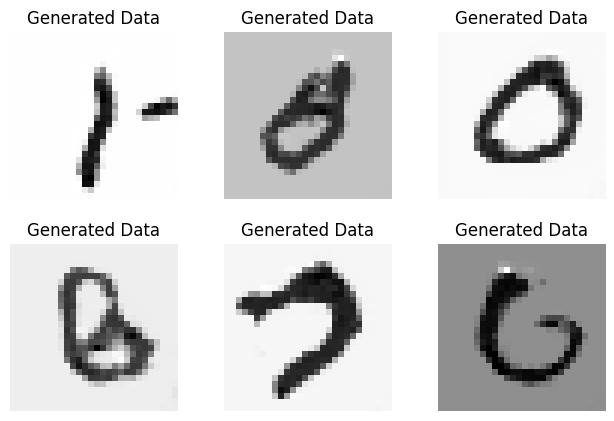

epoch  26


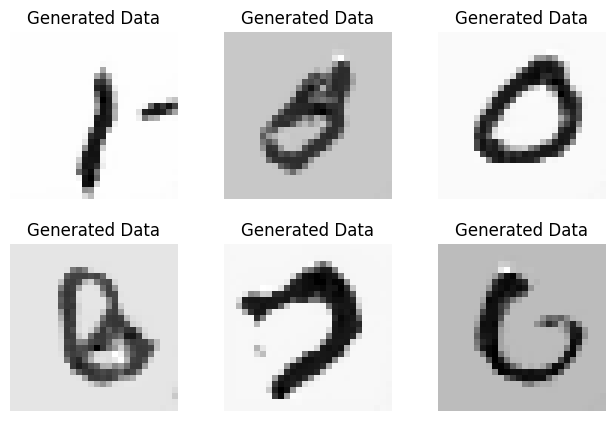

epoch  27


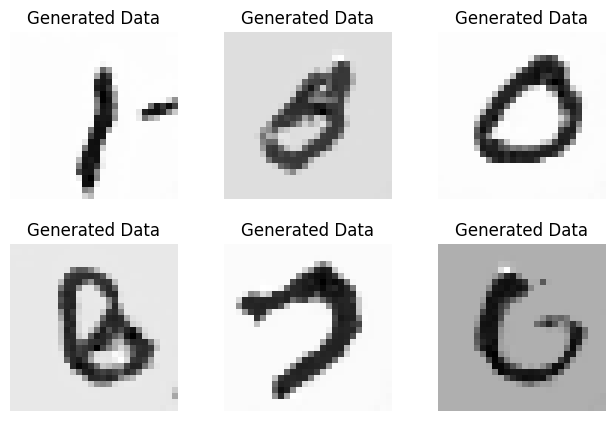

epoch  28


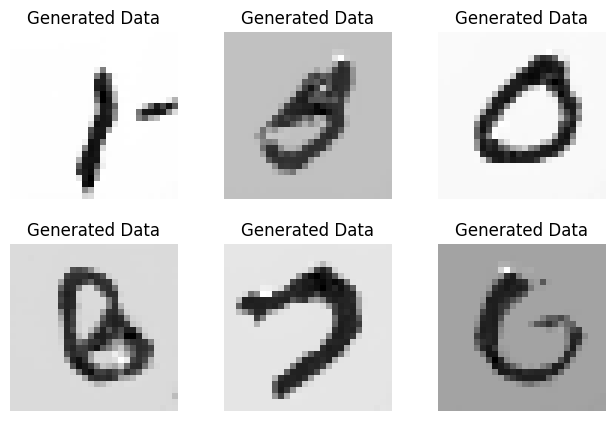

epoch  29


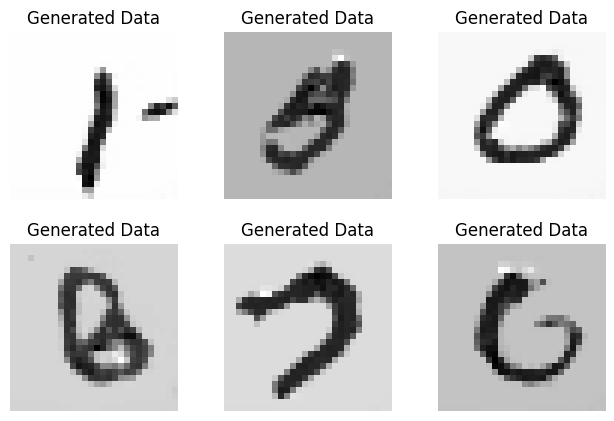

epoch  30


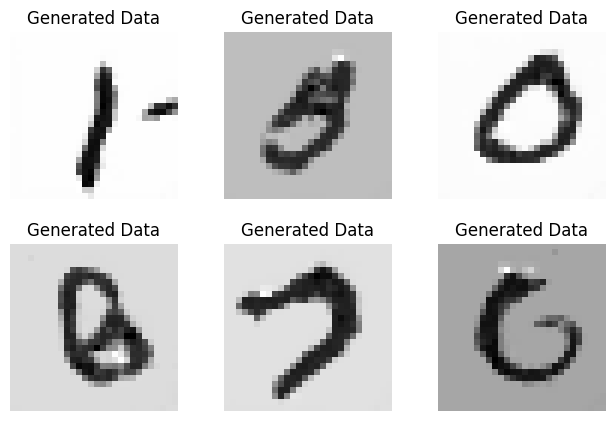

epoch  31


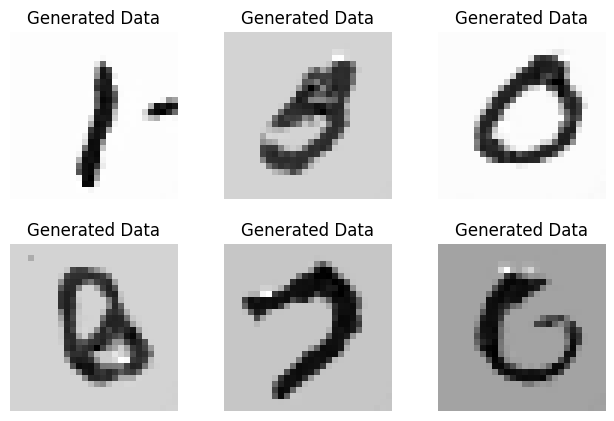

epoch  32


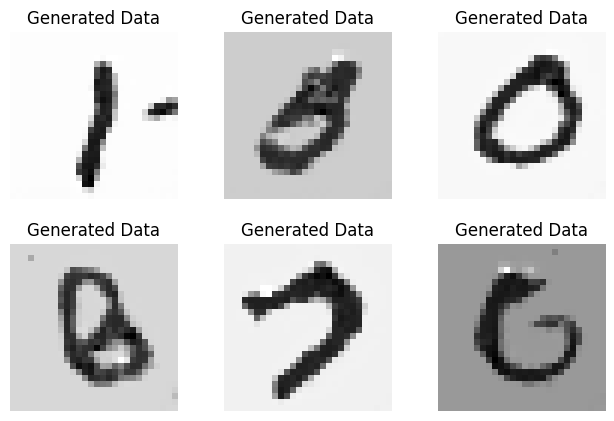

epoch  33


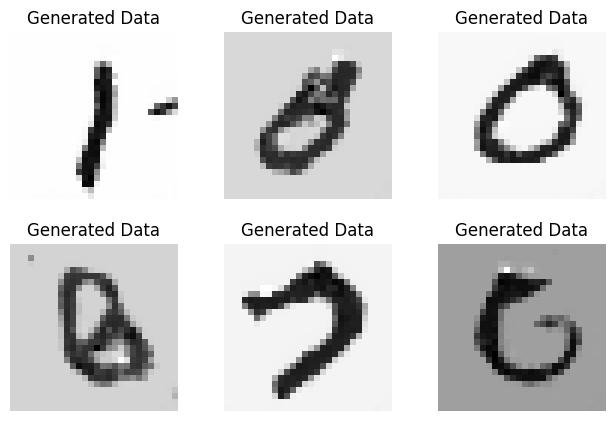

epoch  34


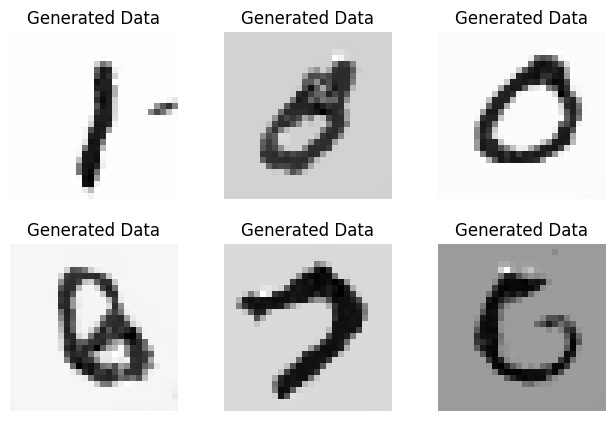

epoch  35


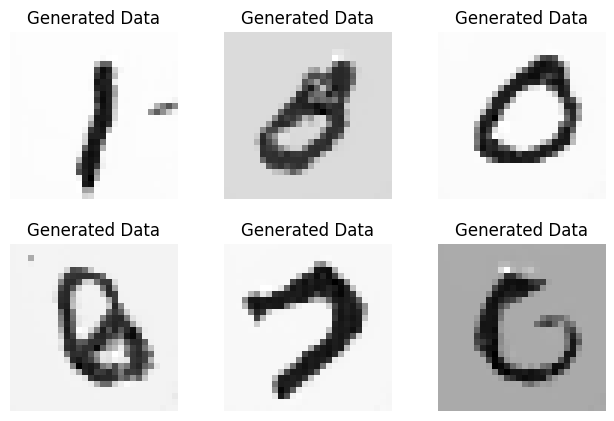

epoch  36


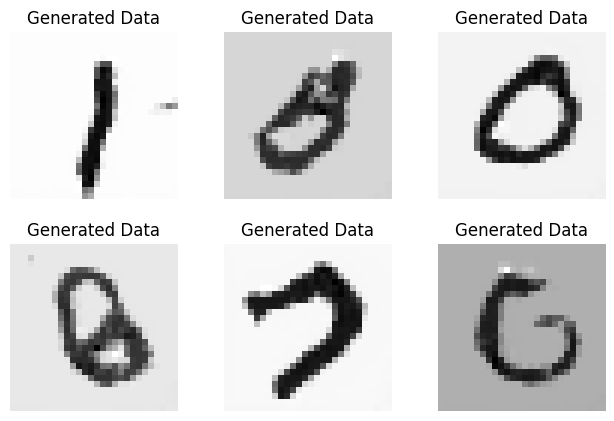

epoch  37


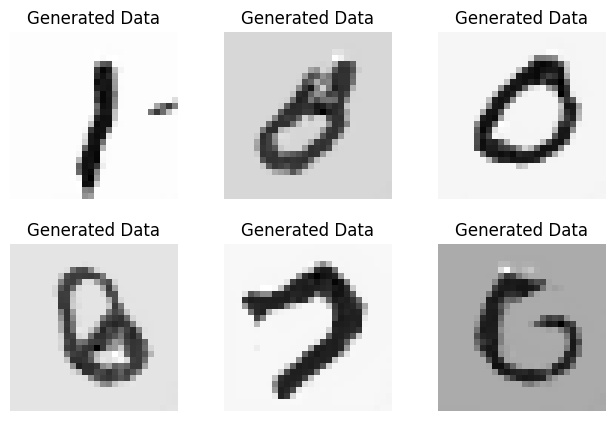

epoch  38


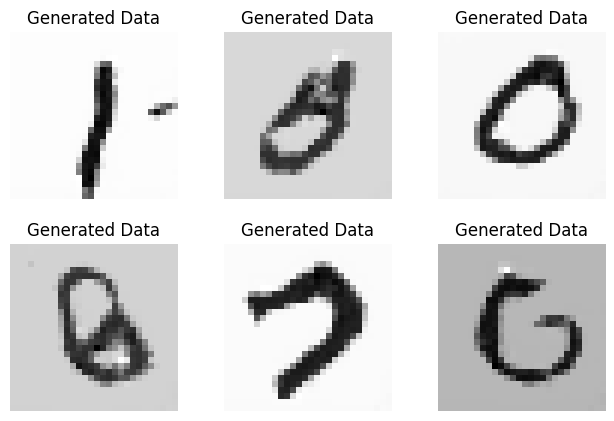

epoch  39


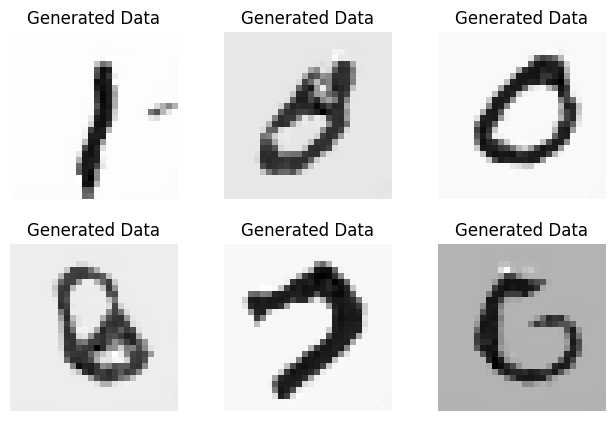

epoch  40


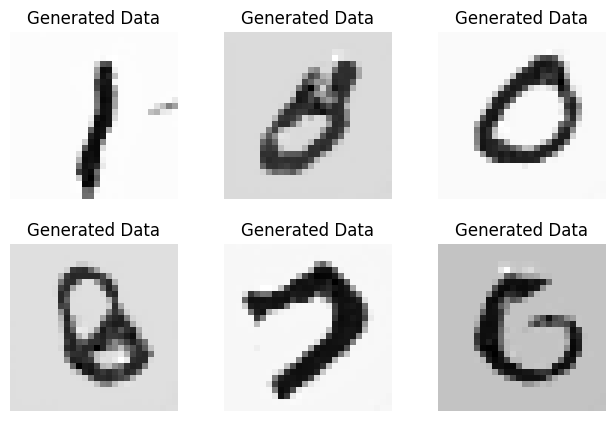

epoch  41


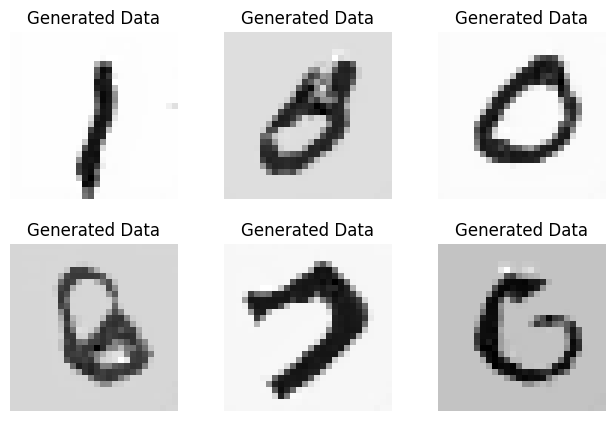

epoch  42


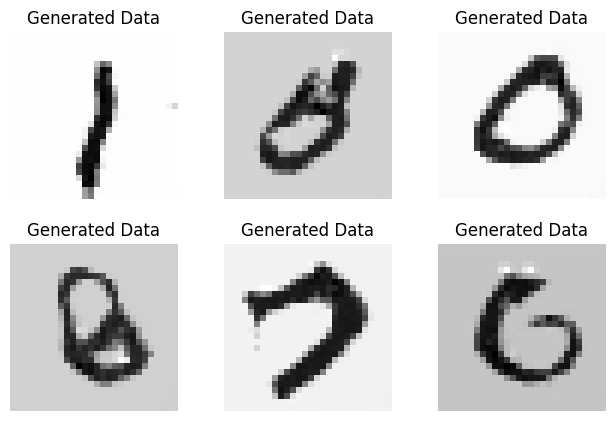

epoch  43


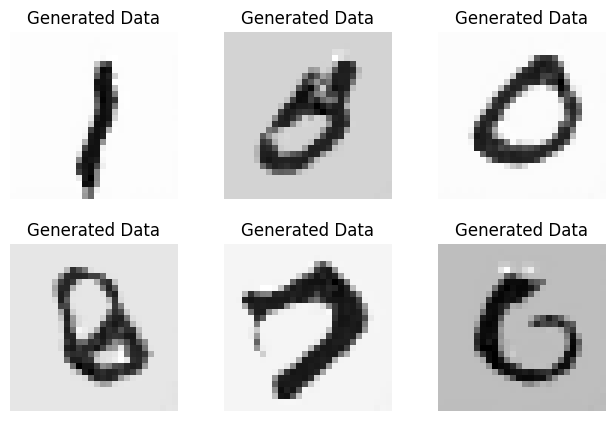

epoch  44


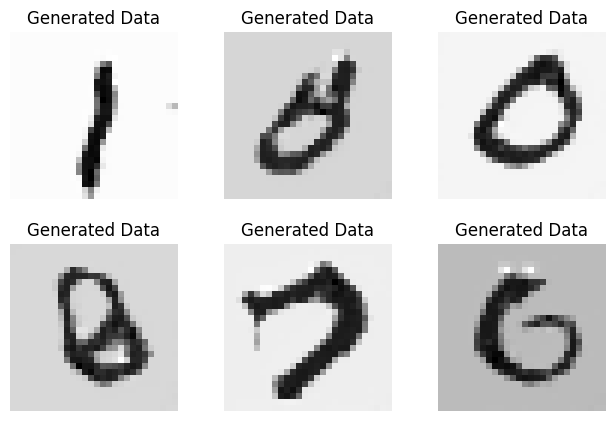

epoch  45


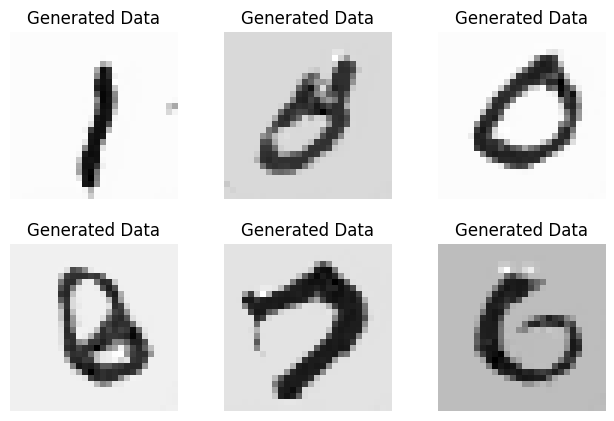

epoch  46


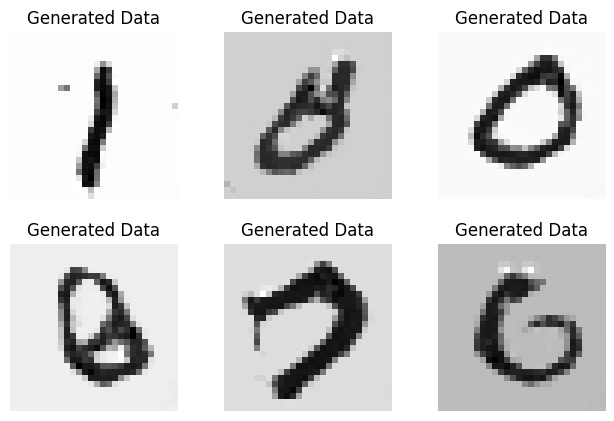

epoch  47


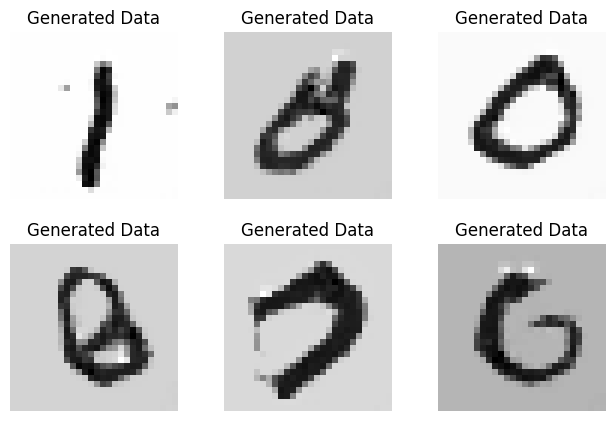

epoch  48


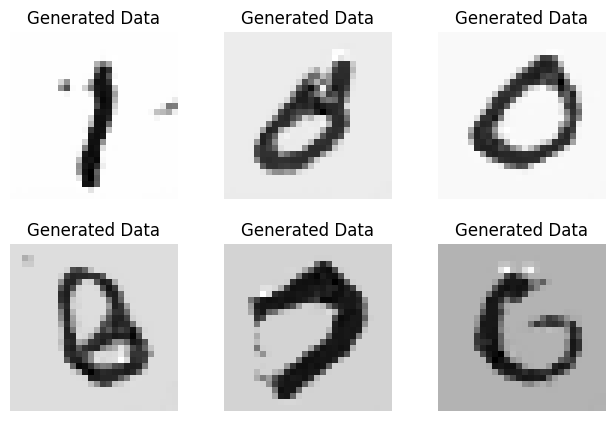

epoch  49


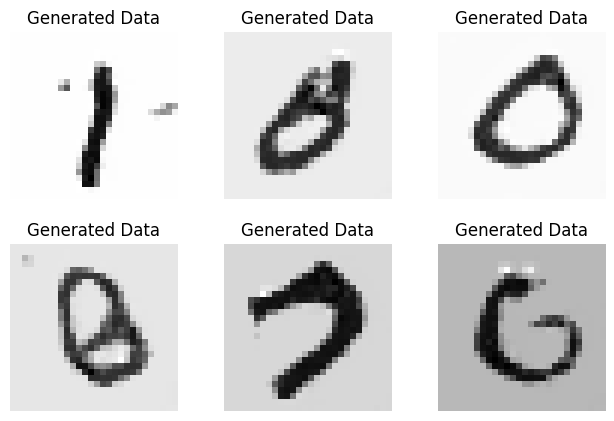

epoch  50


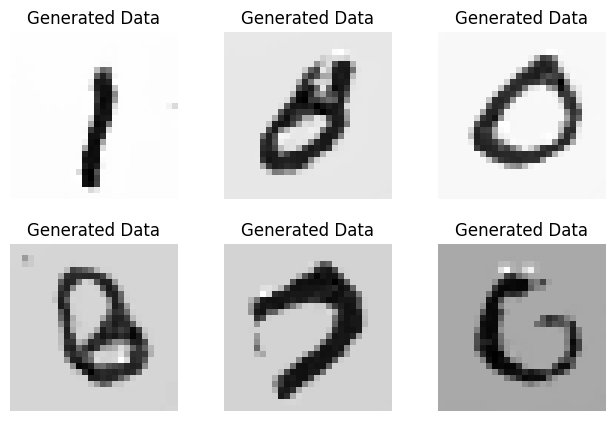

epoch  51


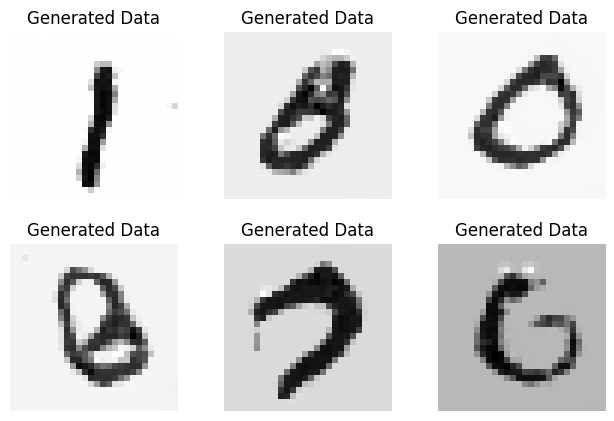

epoch  52


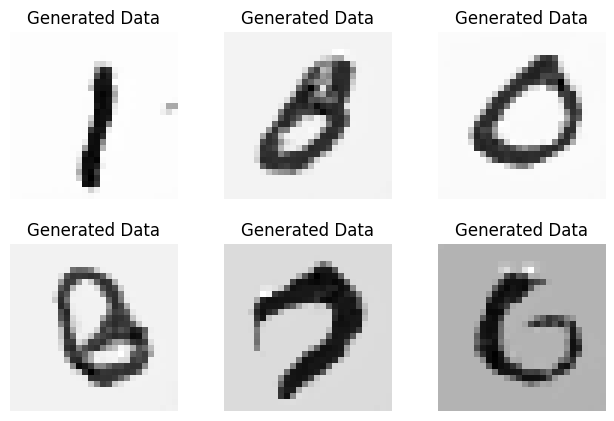

epoch  53


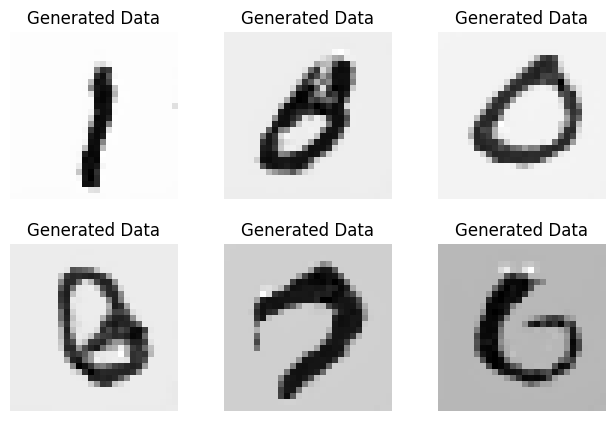

epoch  54


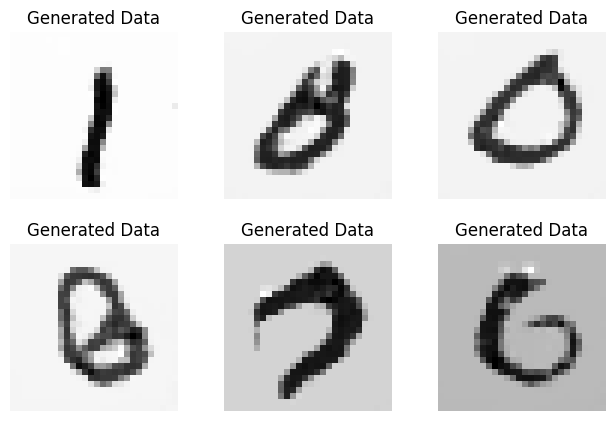

epoch  55


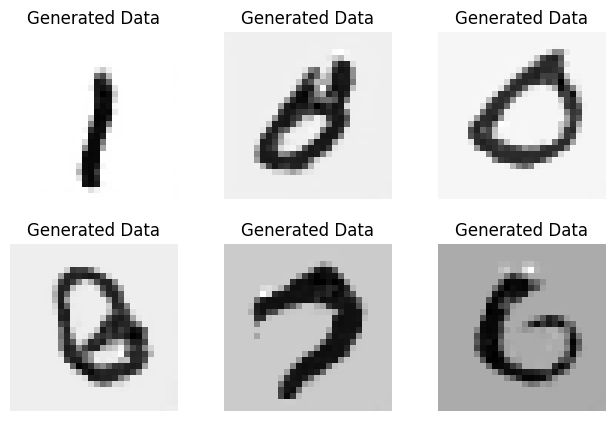

epoch  56


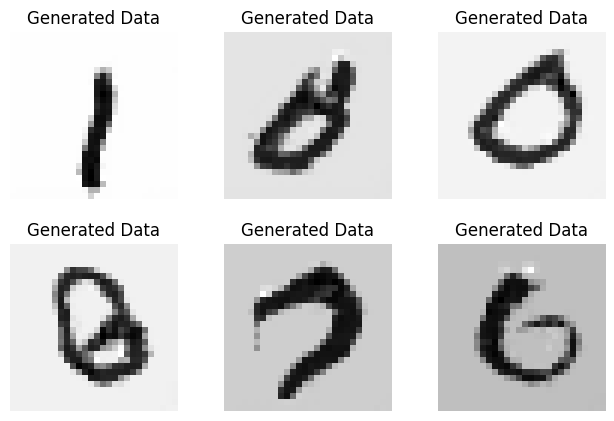

epoch  57


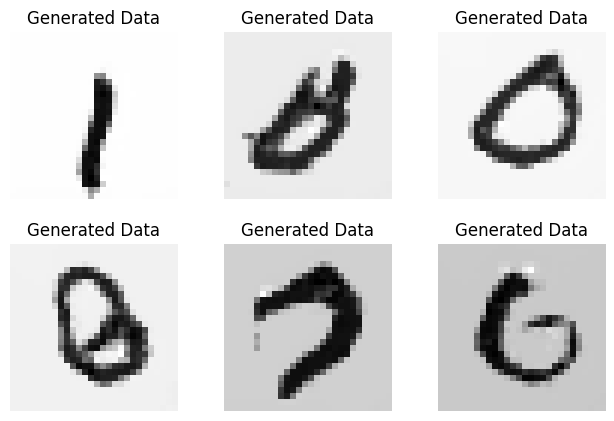

epoch  58


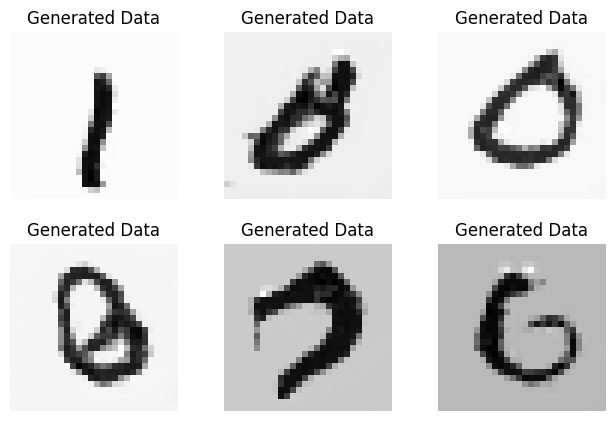

epoch  59


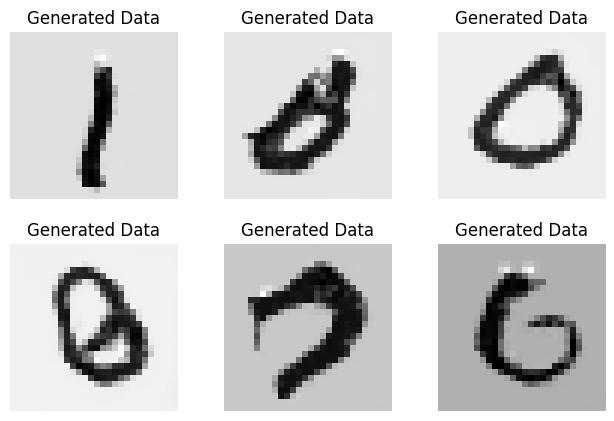

epoch  60


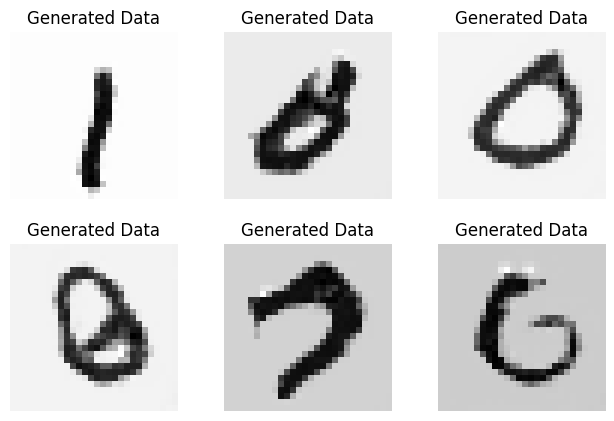

epoch  61


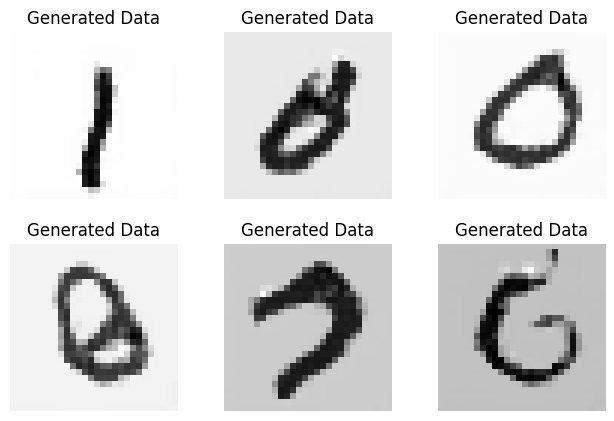

epoch  62


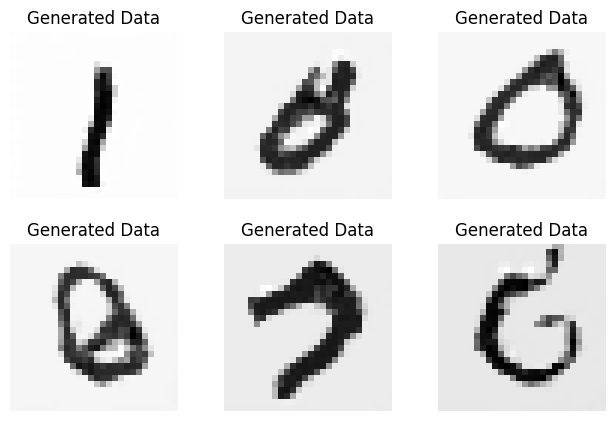

epoch  63


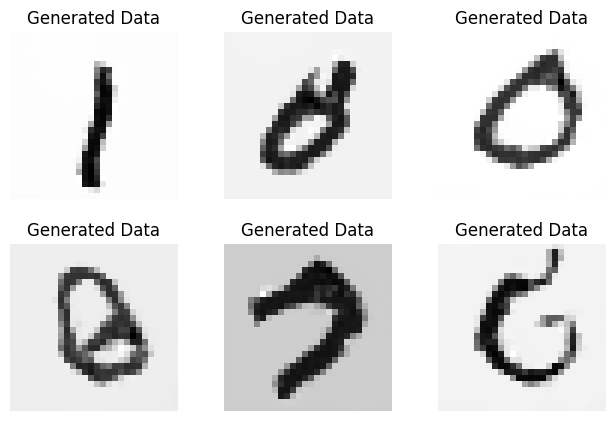

epoch  64


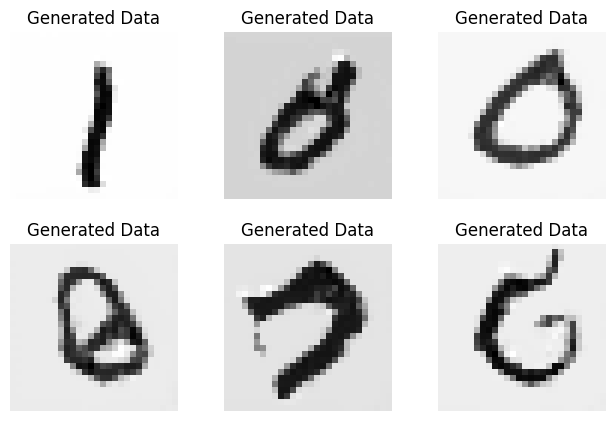

epoch  65


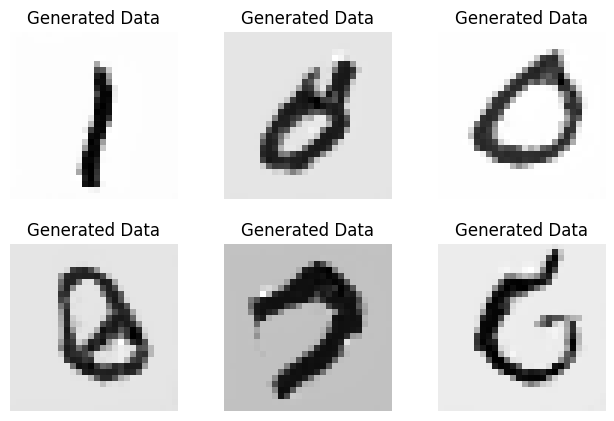

epoch  66


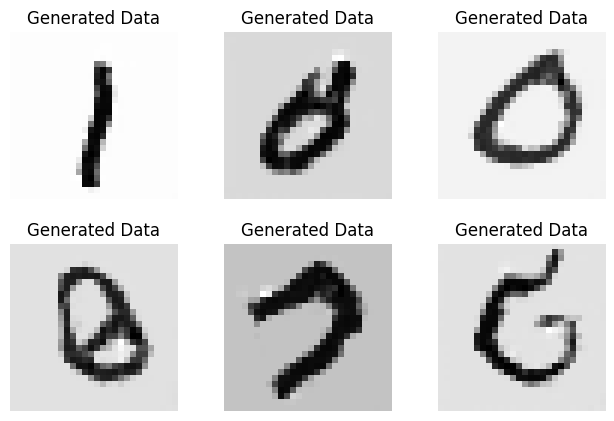

epoch  67


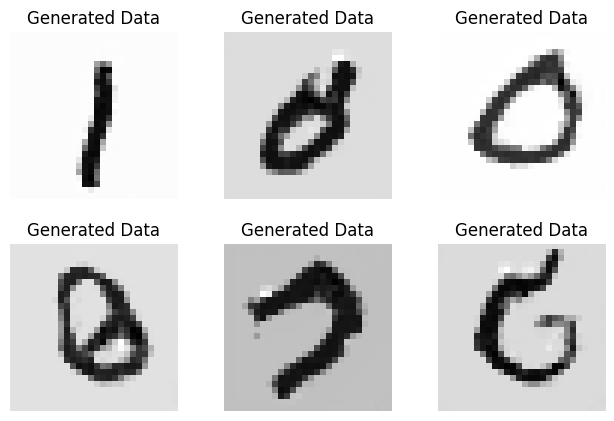

epoch  68


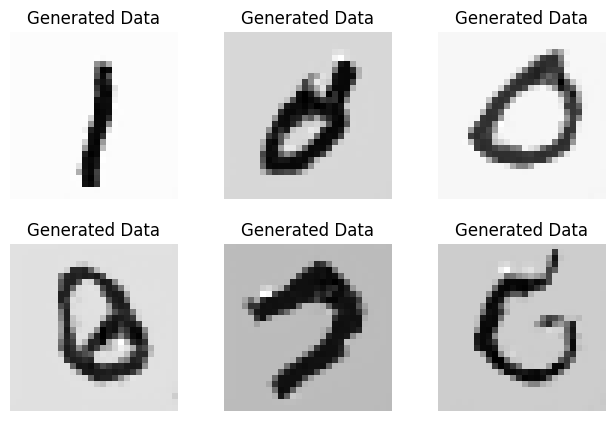

epoch  69


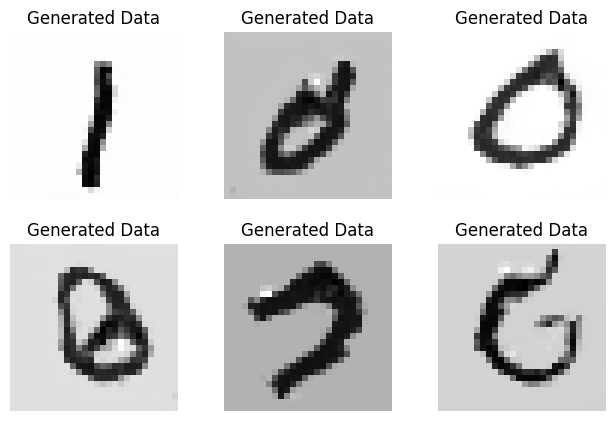

epoch  70


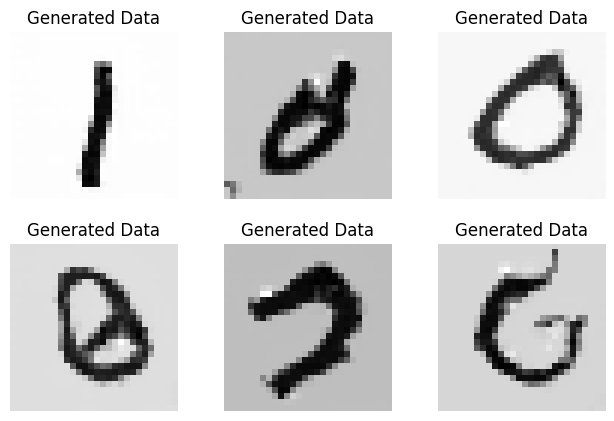

epoch  71


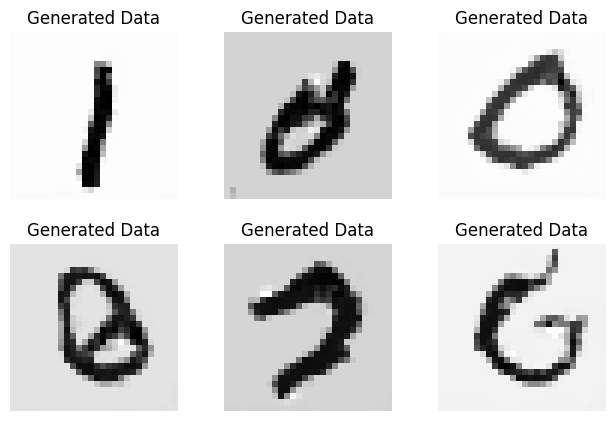

epoch  72


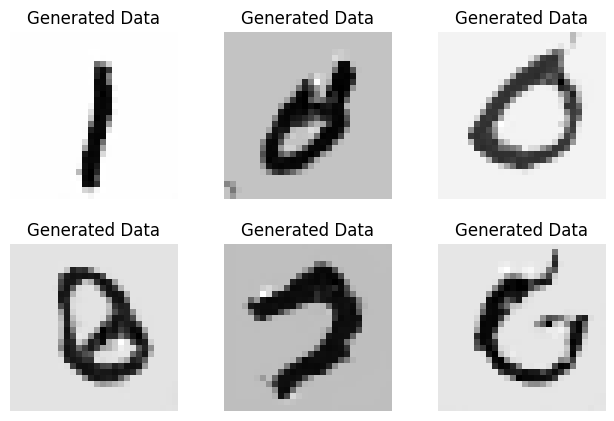

epoch  73


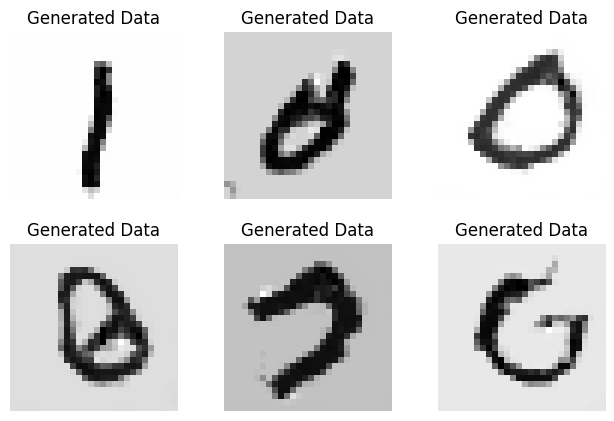

epoch  74


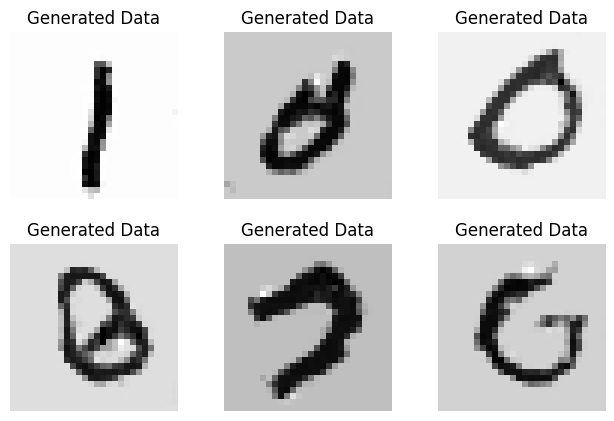

epoch  75


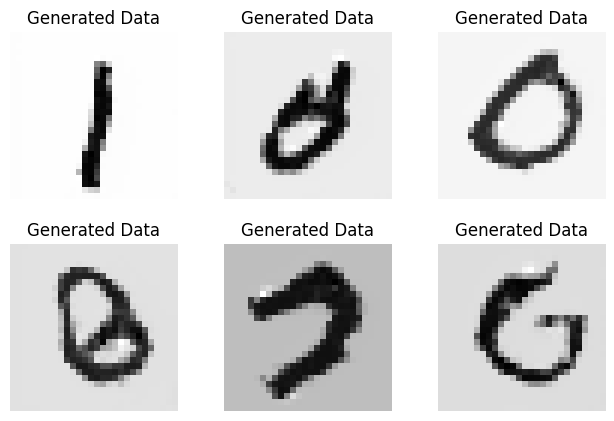

epoch  76


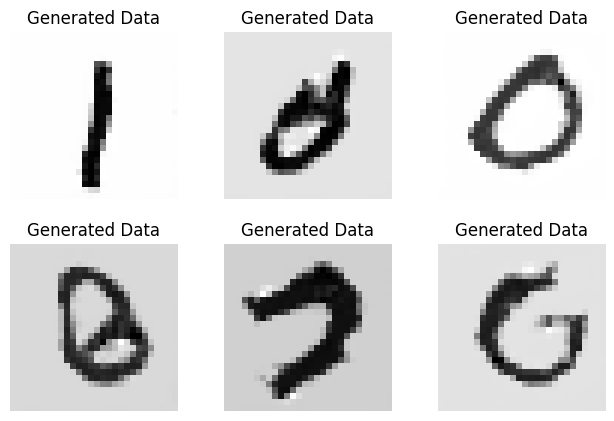

epoch  77


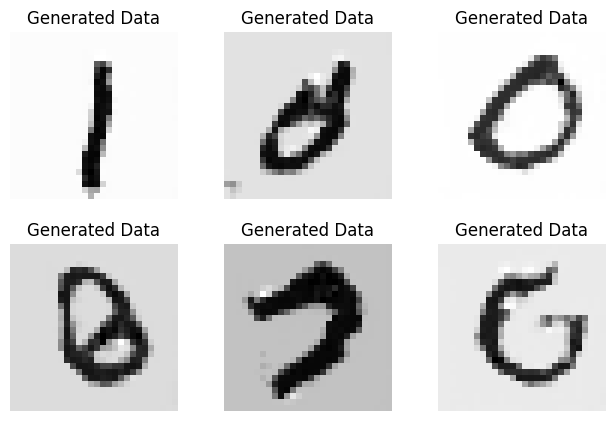

epoch  78


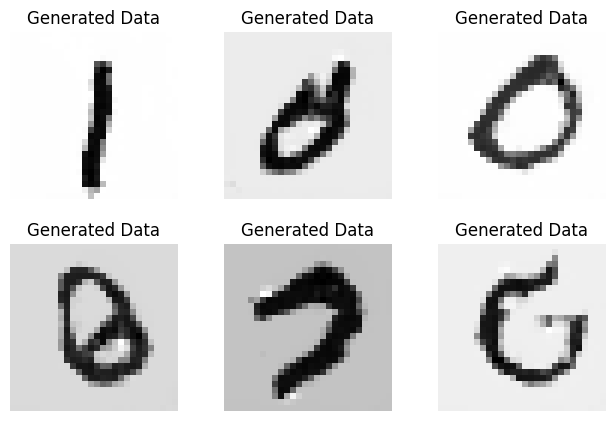

epoch  79


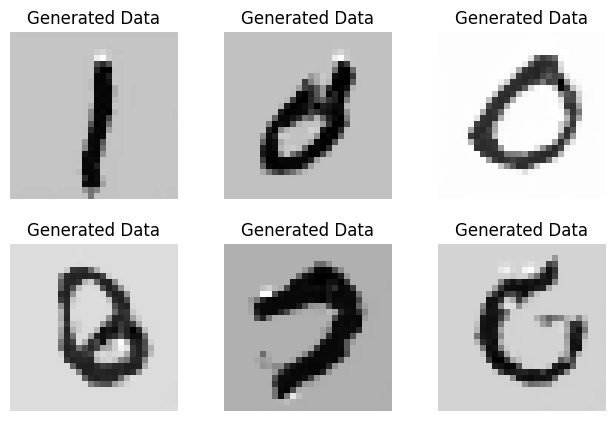

epoch  80


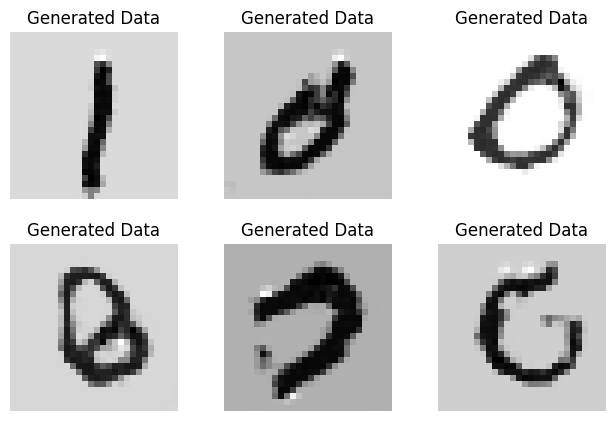

epoch  81


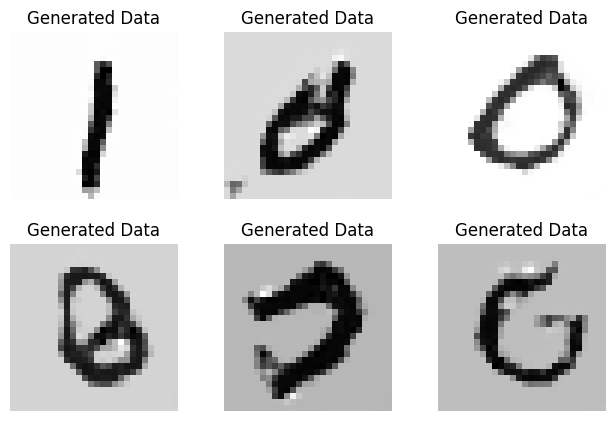

epoch  82


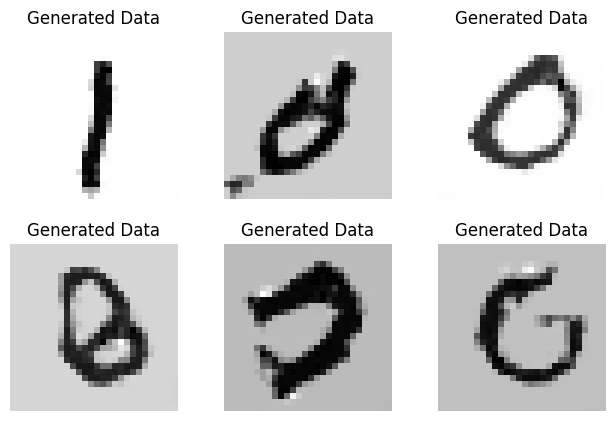

epoch  83


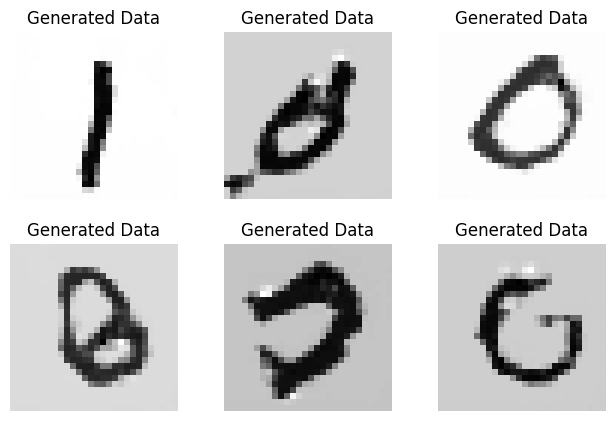

epoch  84


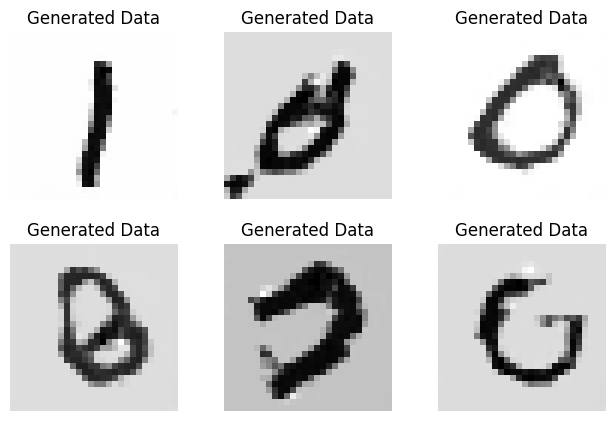

epoch  85


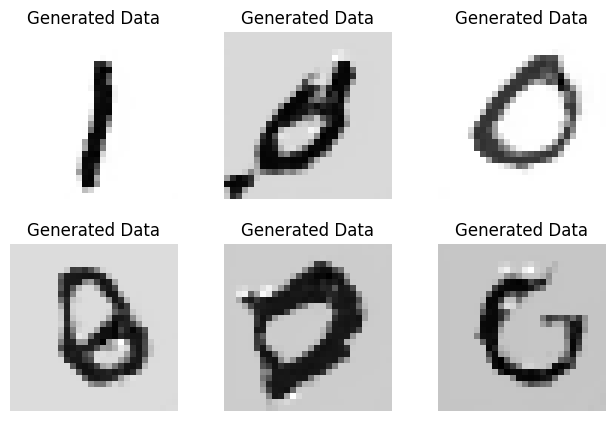

epoch  86


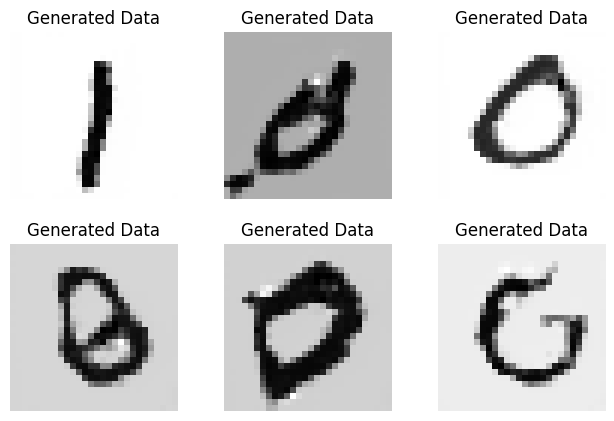

epoch  87


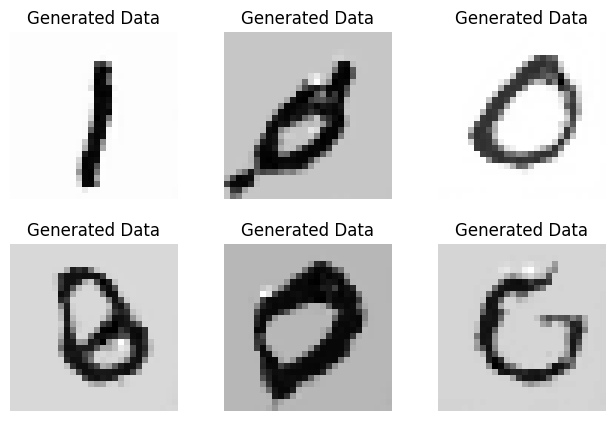

epoch  88


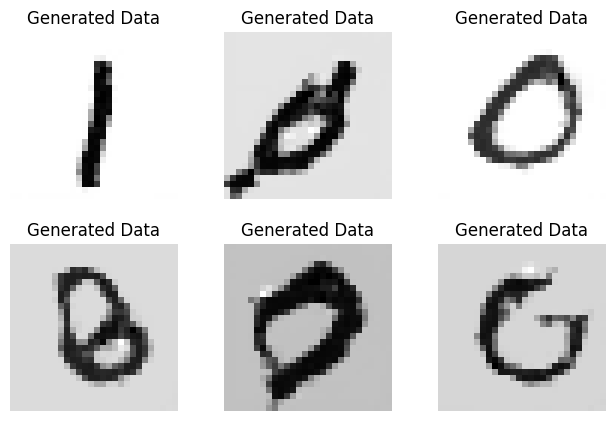

epoch  89


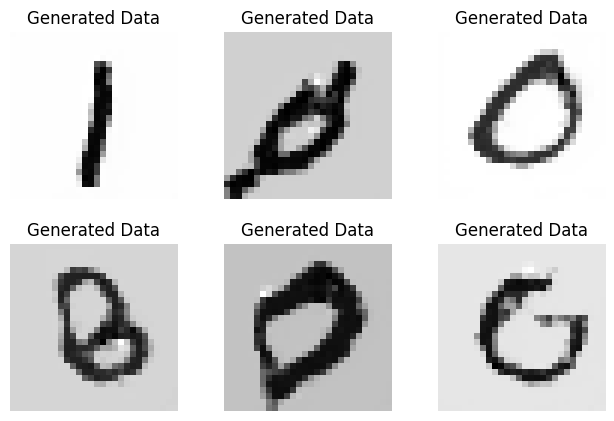

epoch  90


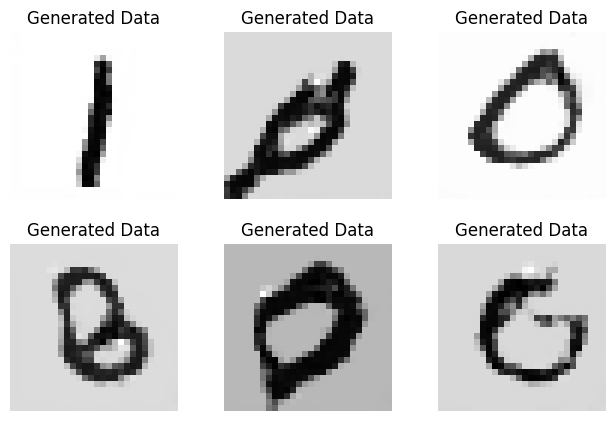

epoch  91


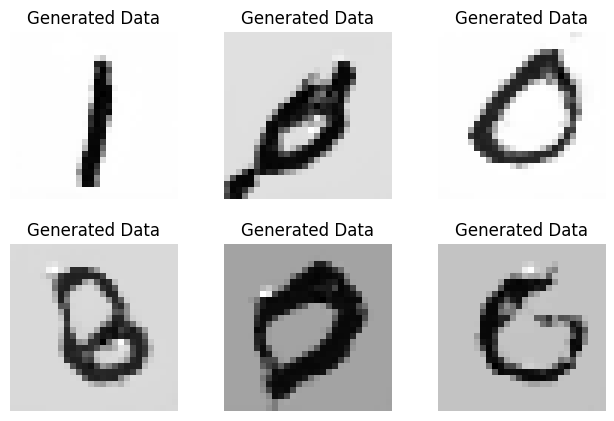

epoch  92


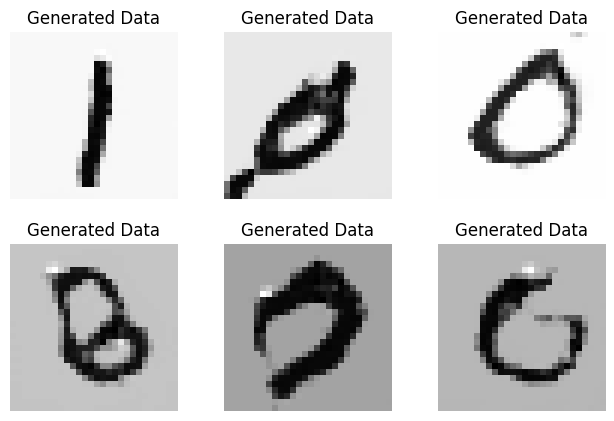

epoch  93


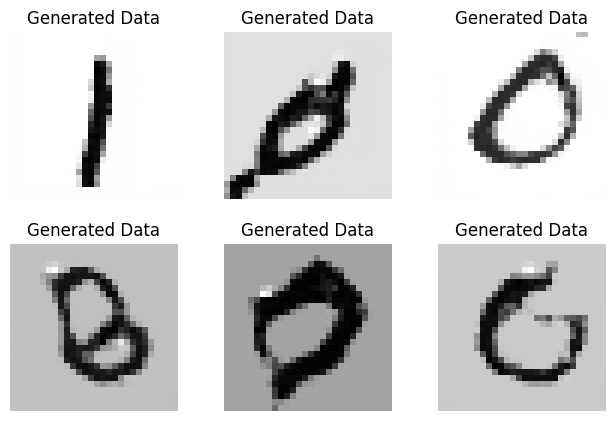

epoch  94


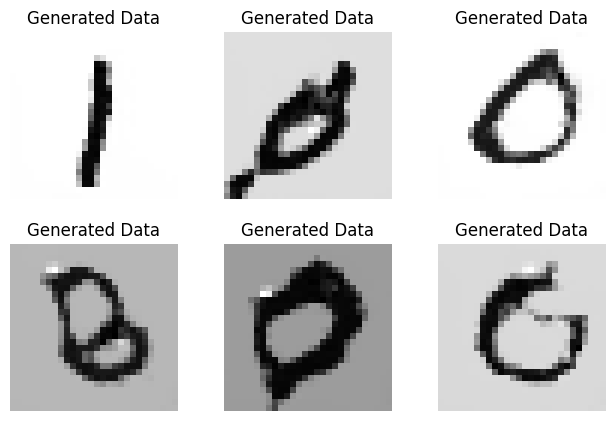

epoch  95


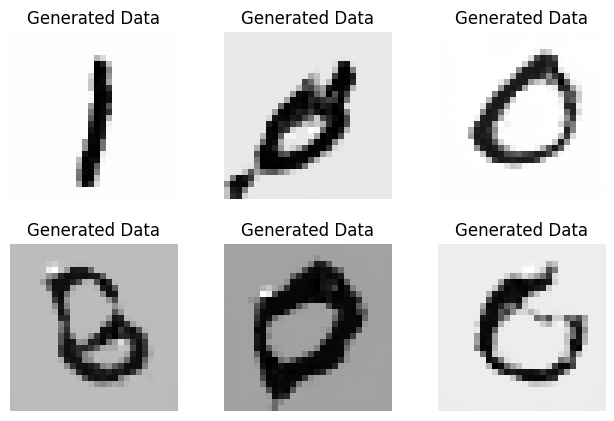

epoch  96


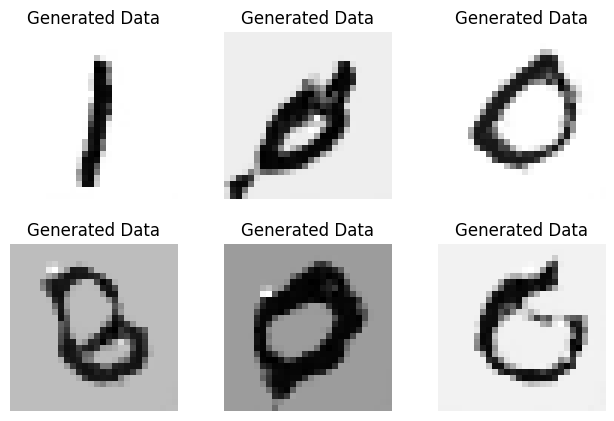

epoch  97


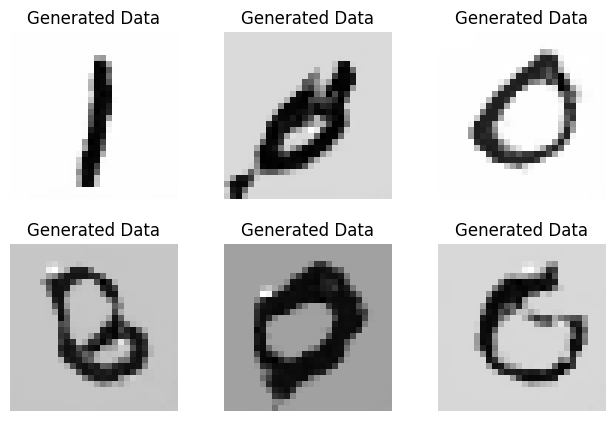

epoch  98


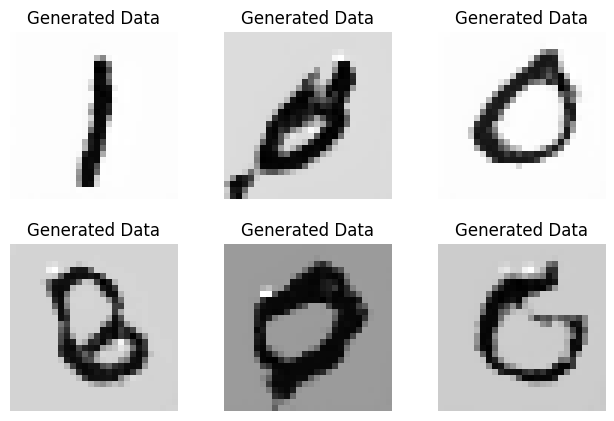

epoch  99


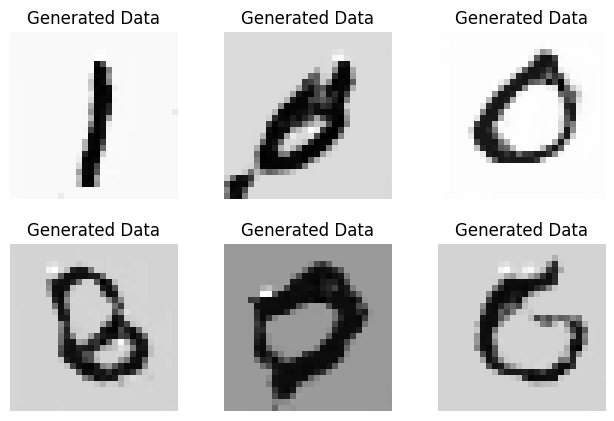

epoch  100


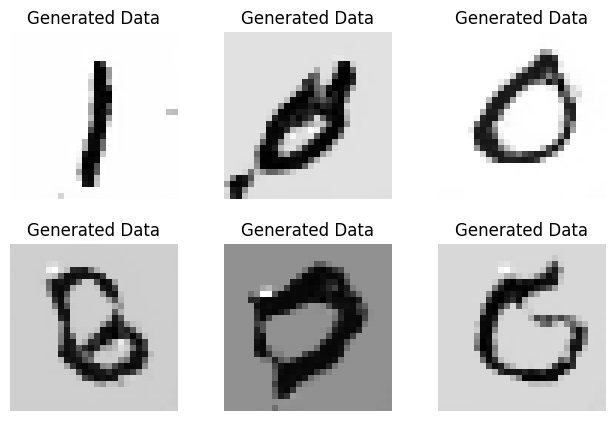

epoch  101


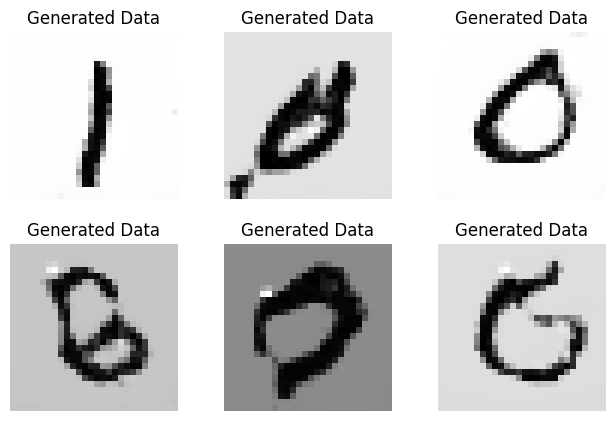

epoch  102


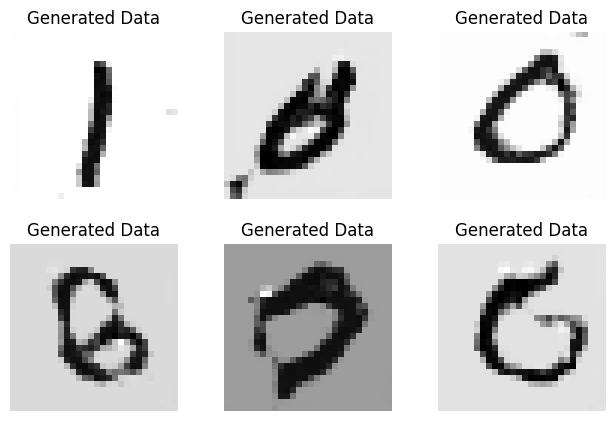

epoch  103


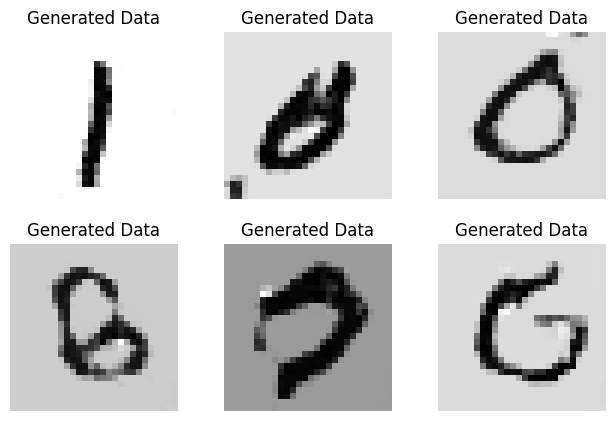

epoch  104


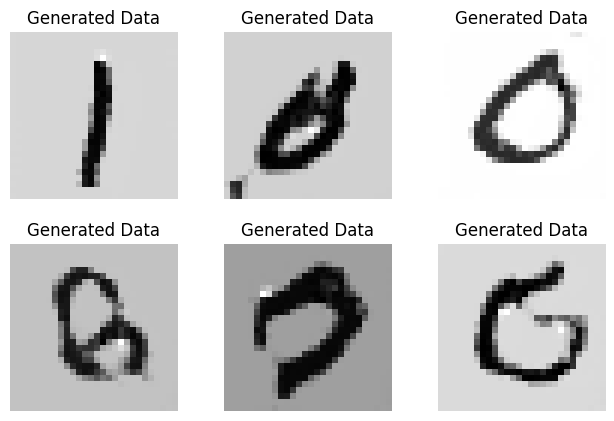

epoch  105


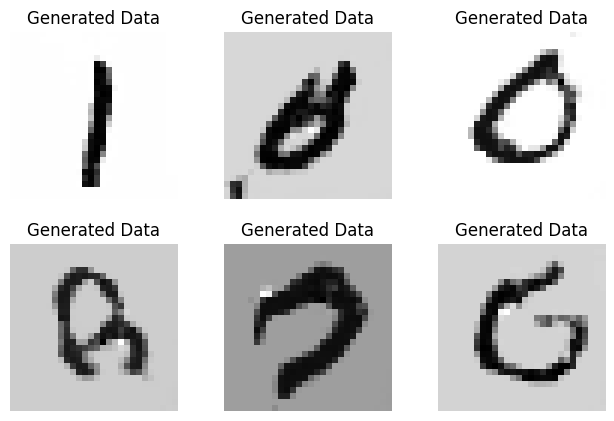

epoch  106


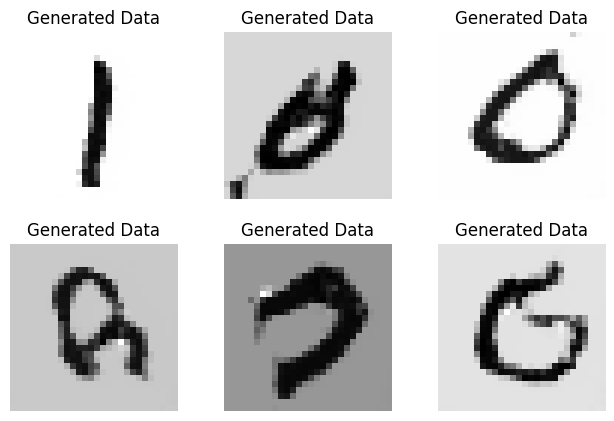

epoch  107


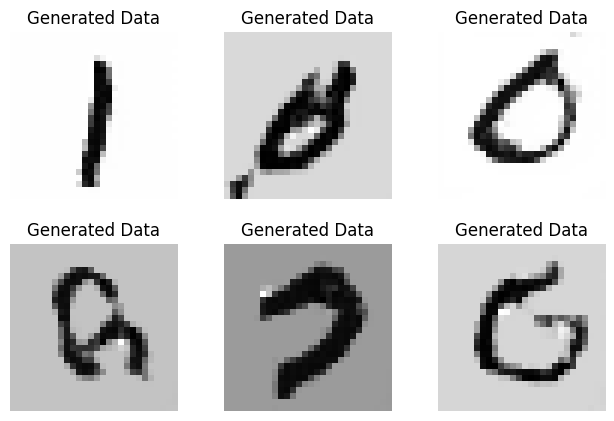

epoch  108


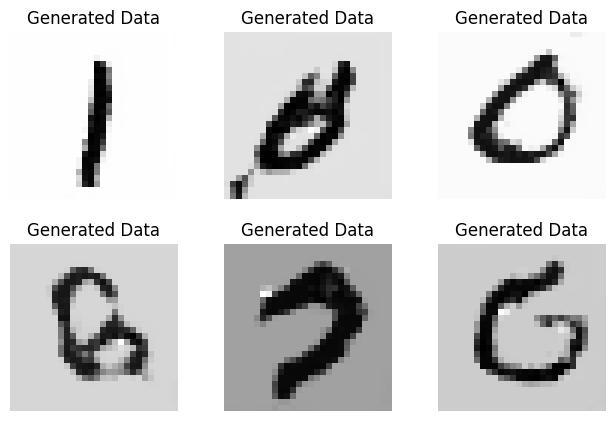

epoch  109


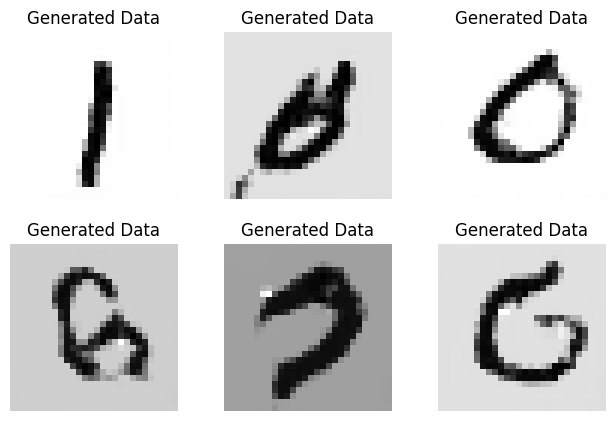

epoch  110


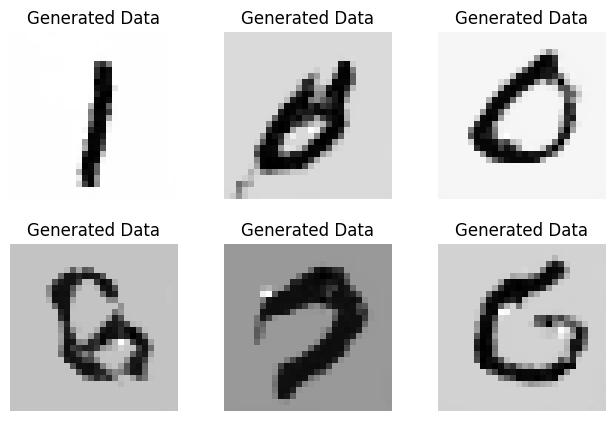

epoch  111


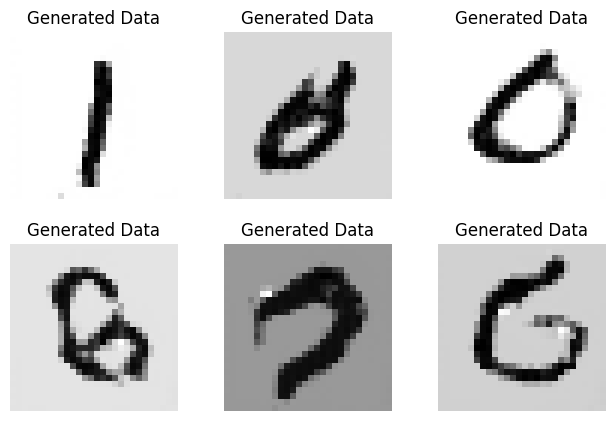

epoch  112


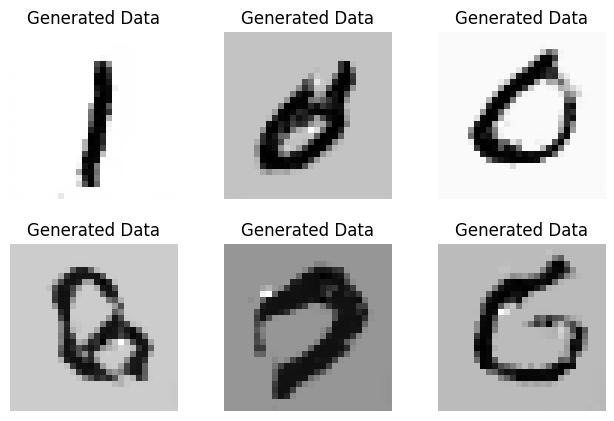

epoch  113


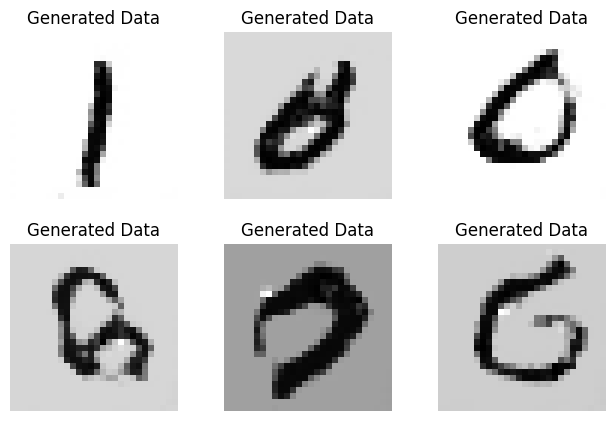

epoch  114


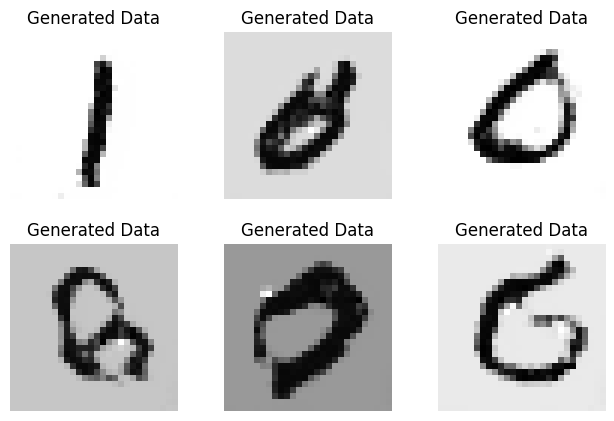

epoch  115


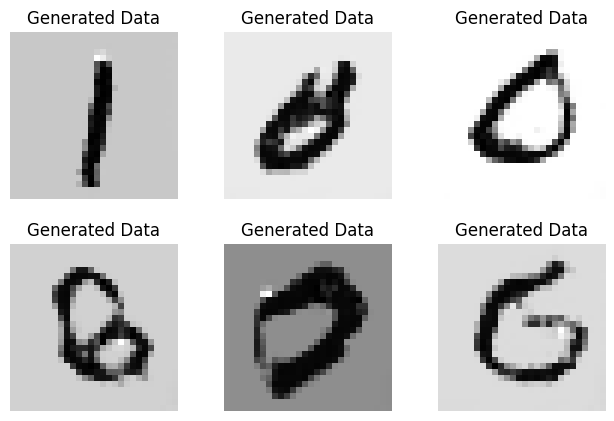

epoch  116


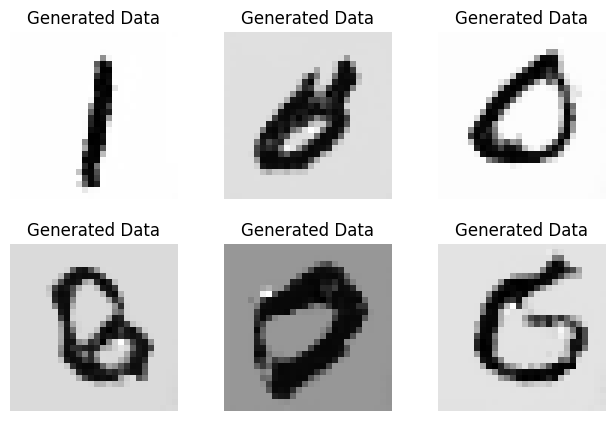

epoch  117


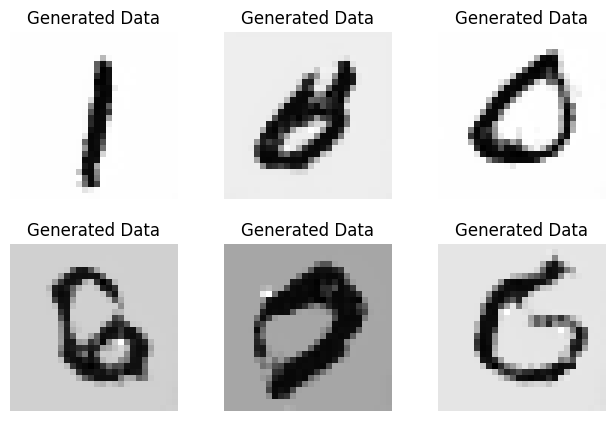

epoch  118


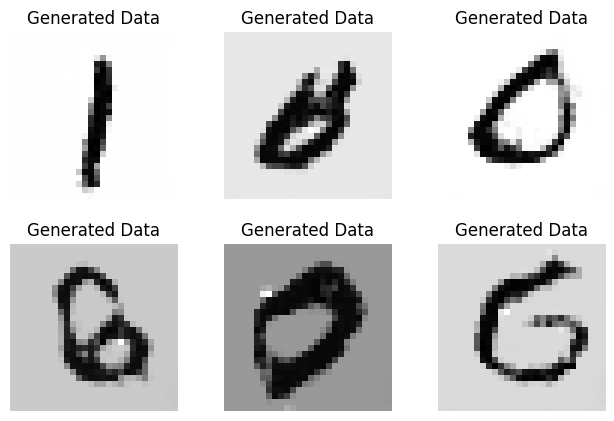

epoch  119


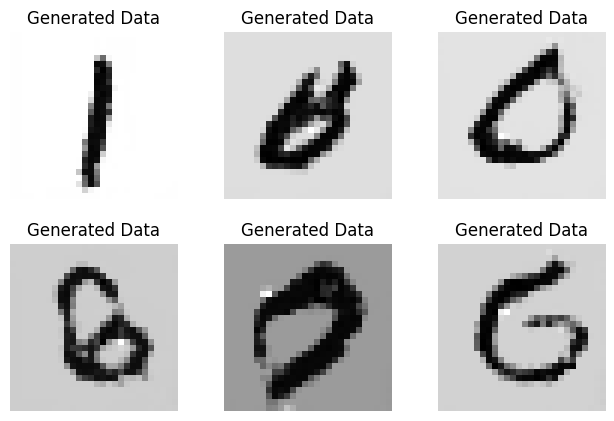

epoch  120


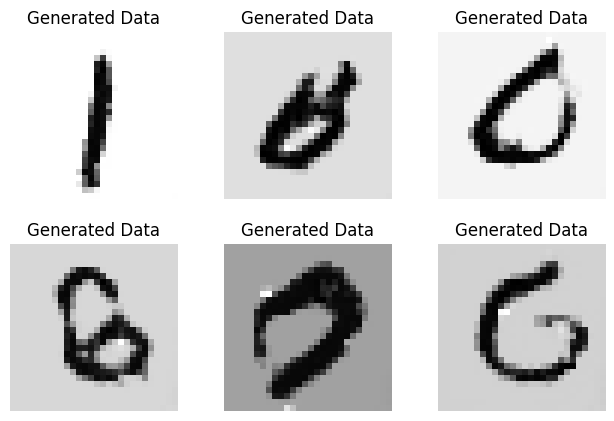

epoch  121


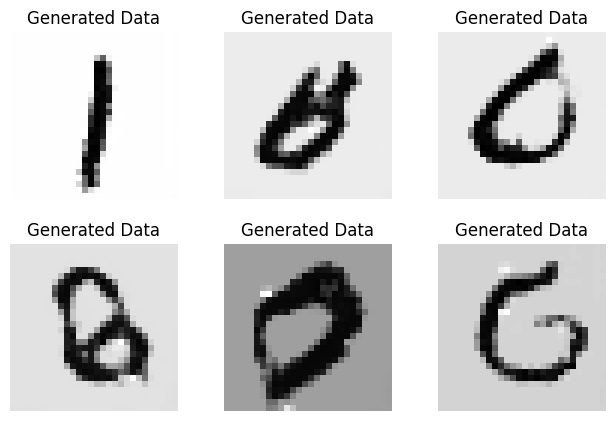

epoch  122


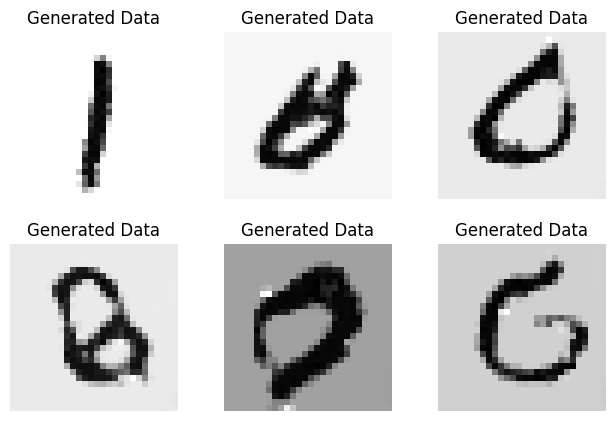

epoch  123


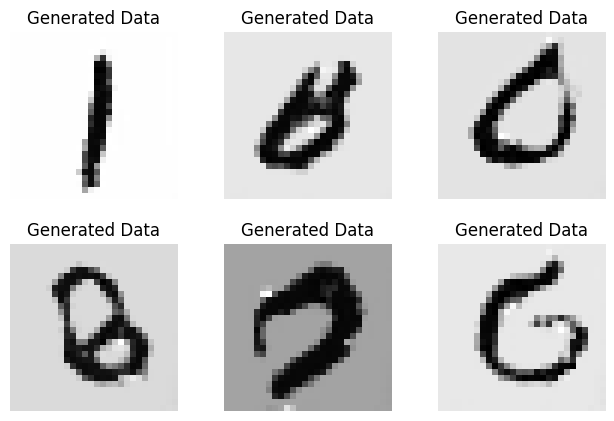

epoch  124


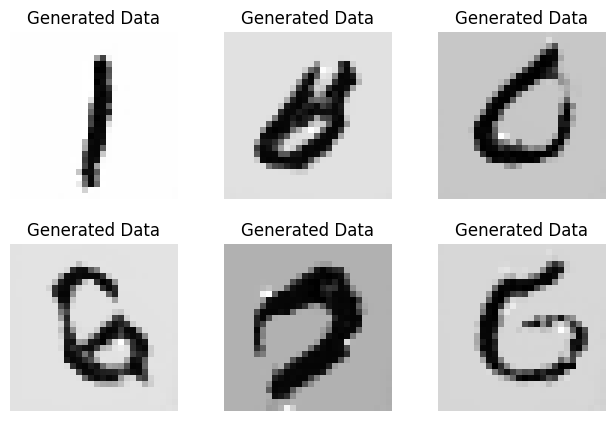

epoch  125


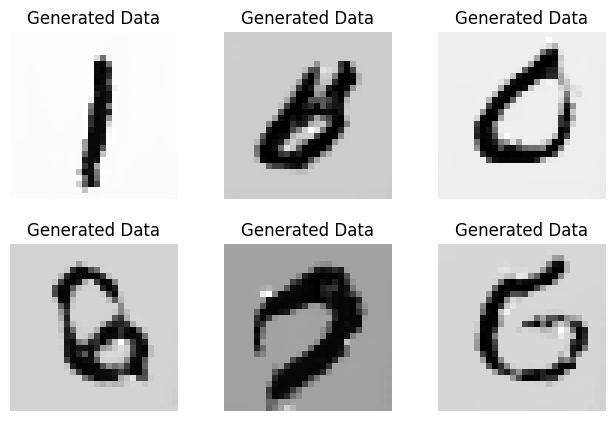

epoch  126


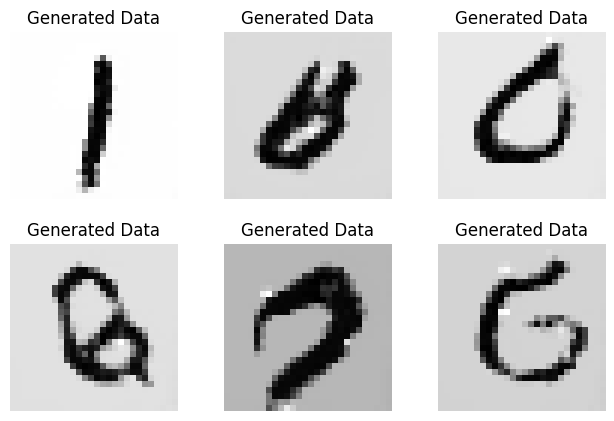

epoch  127


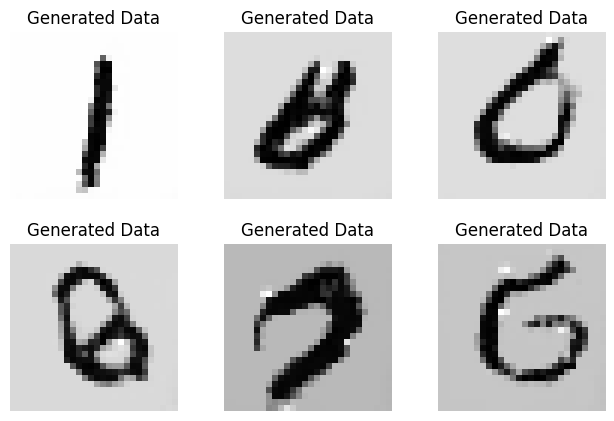

epoch  128


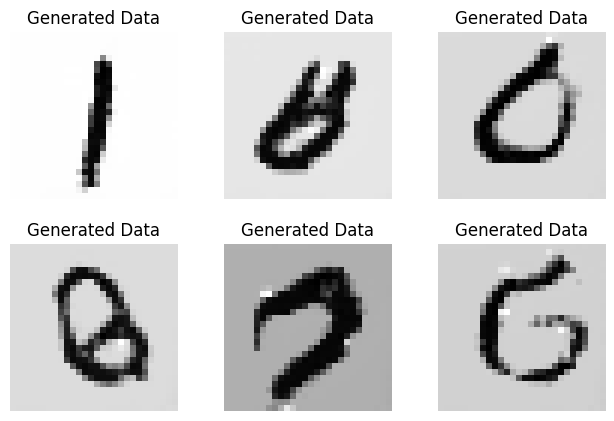

epoch  129


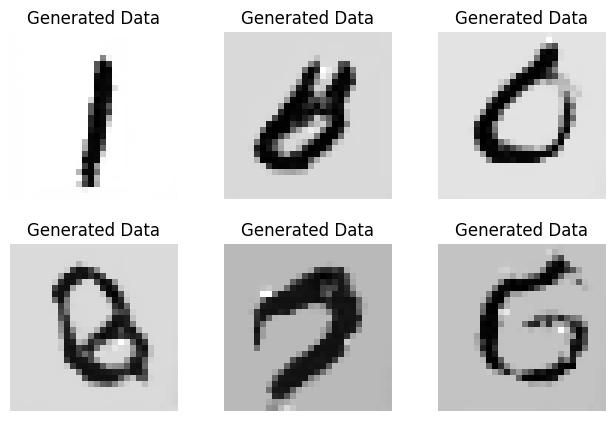

epoch  130


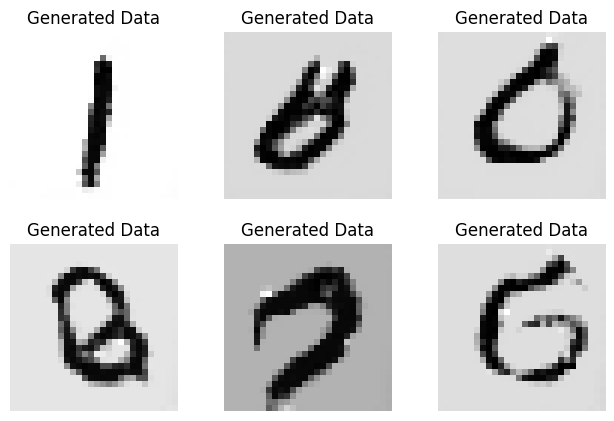

epoch  131


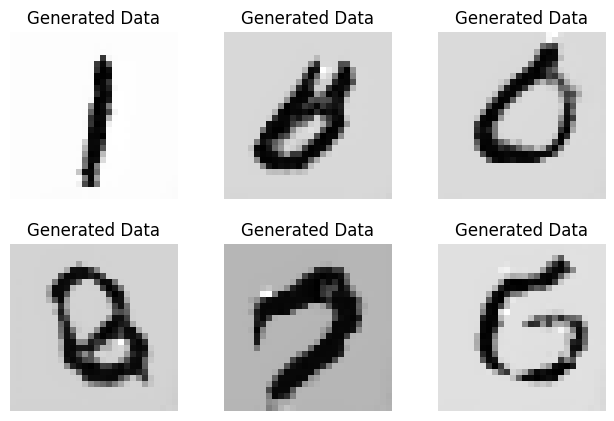

epoch  132


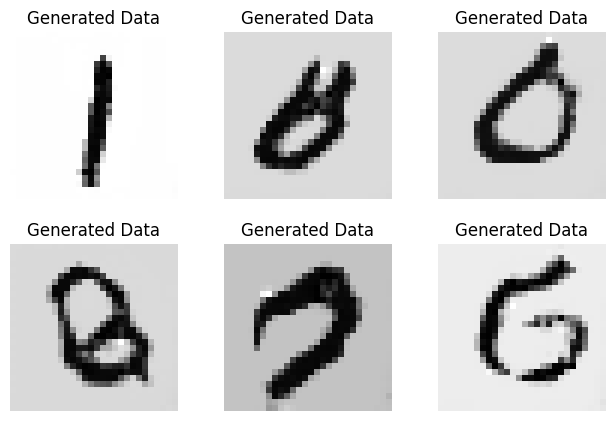

epoch  133


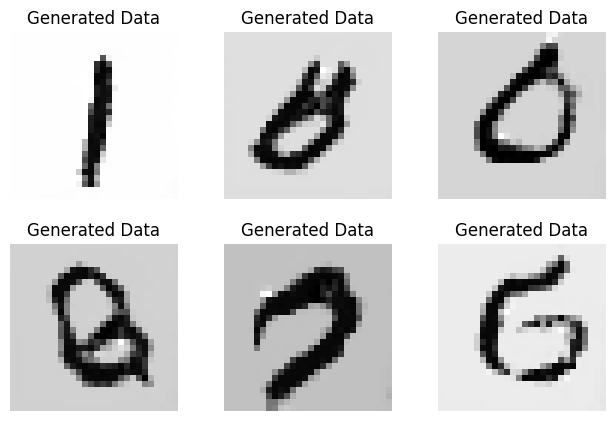

epoch  134


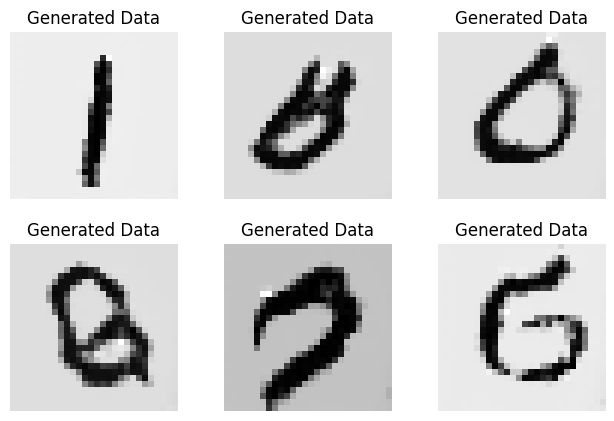

epoch  135


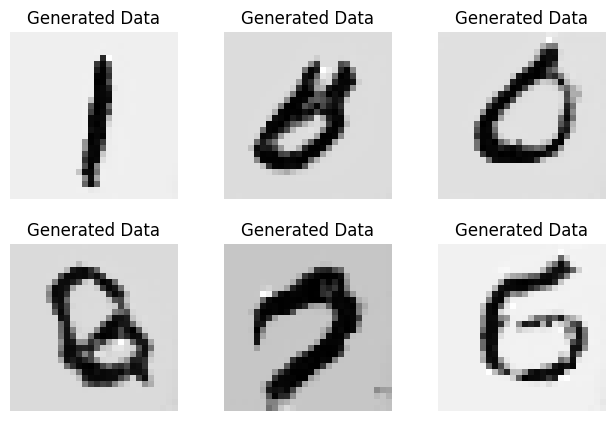

epoch  136


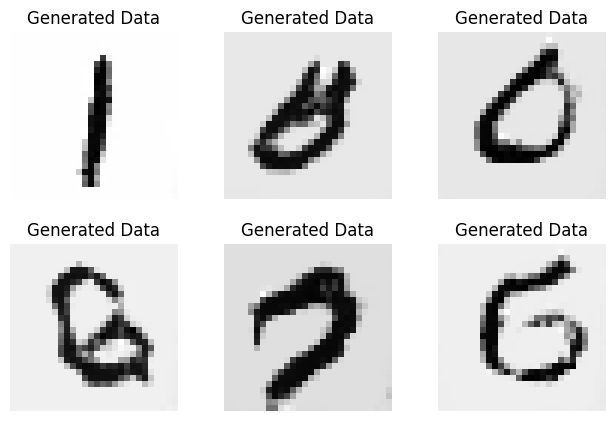

epoch  137


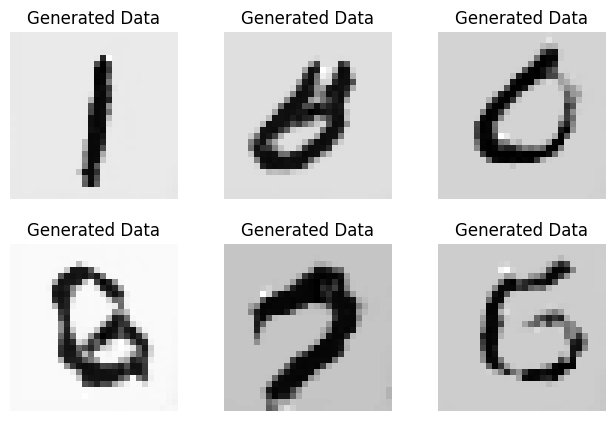

epoch  138


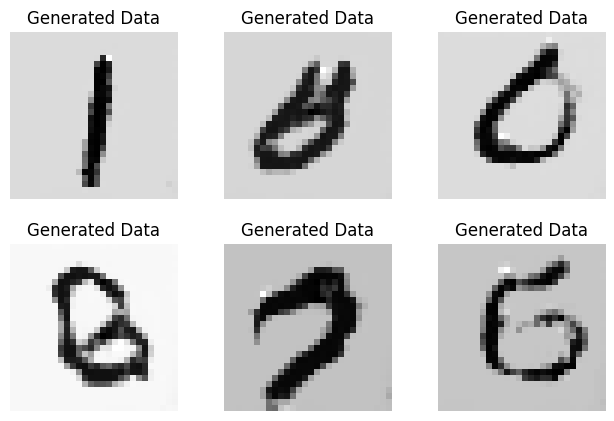

epoch  139


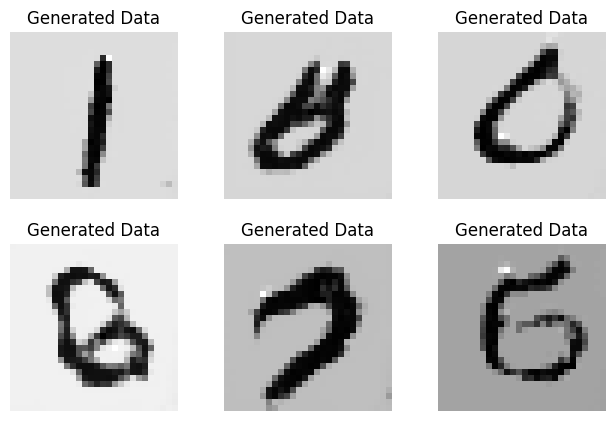

epoch  140


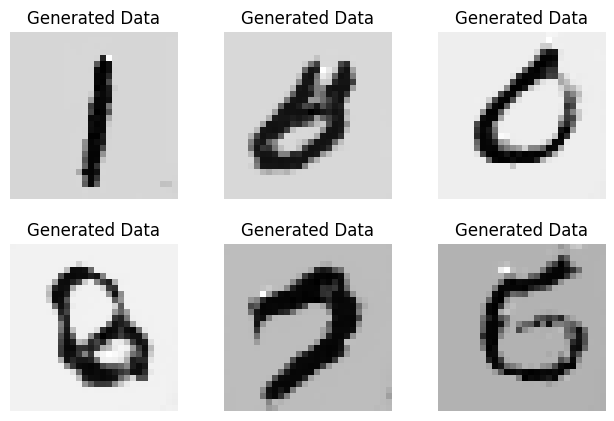

epoch  141


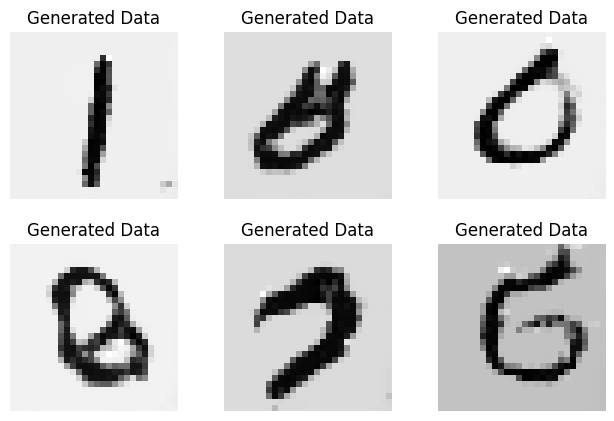

epoch  142


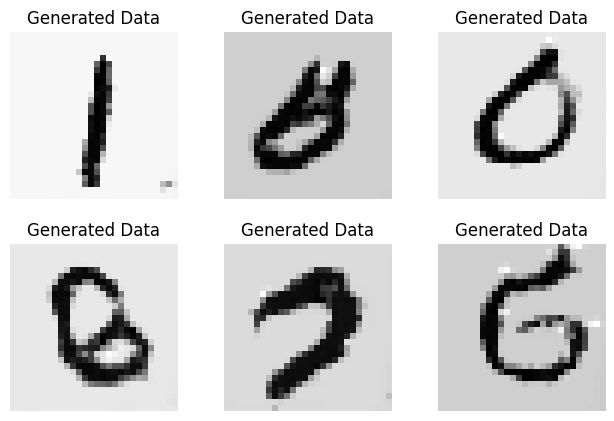

epoch  143


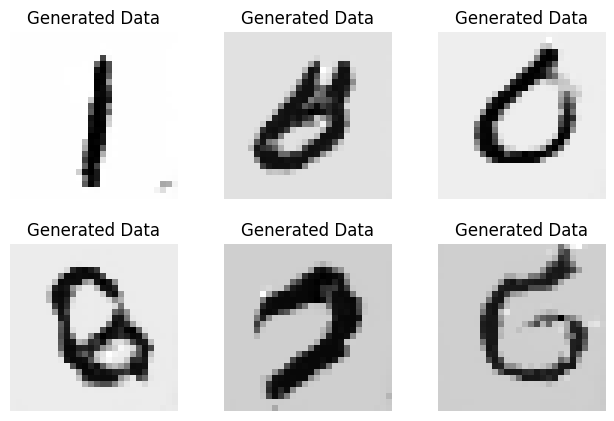

epoch  144


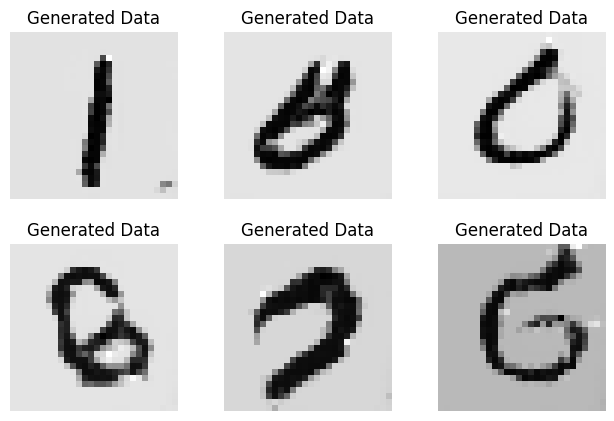

epoch  145


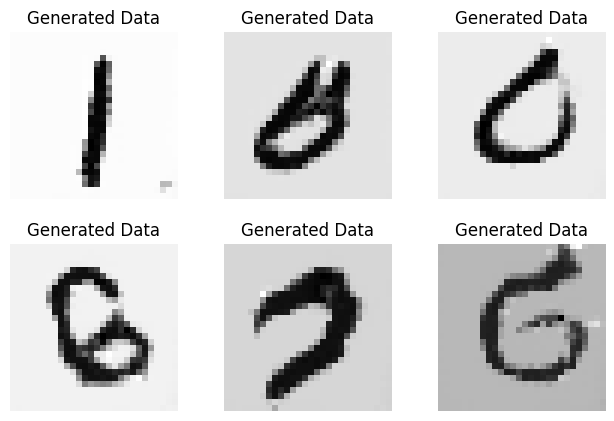

epoch  146


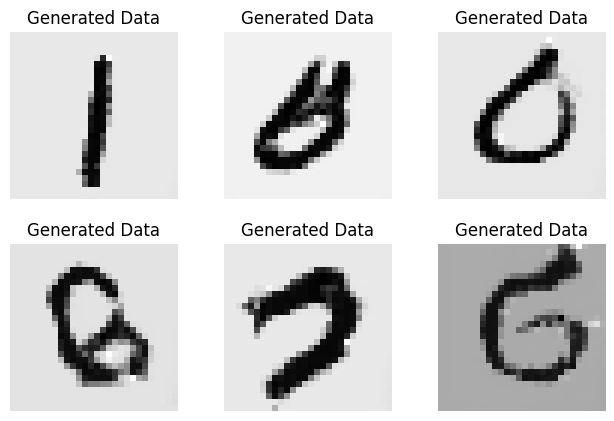

epoch  147


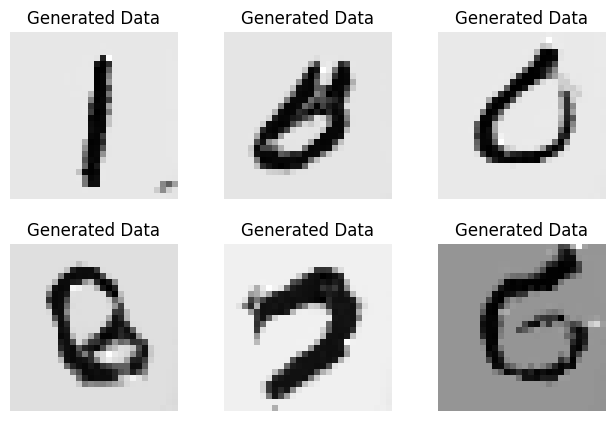

epoch  148


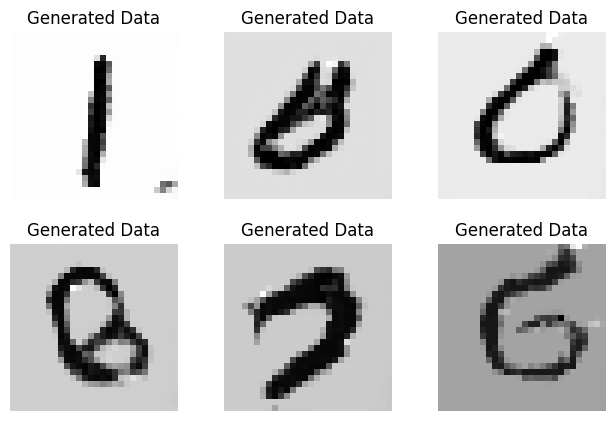

epoch  149


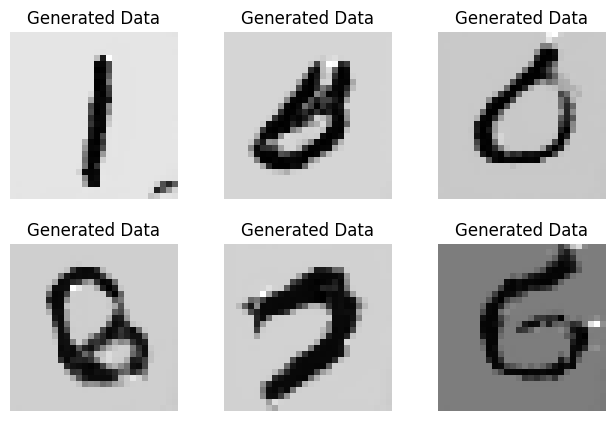

epoch  150


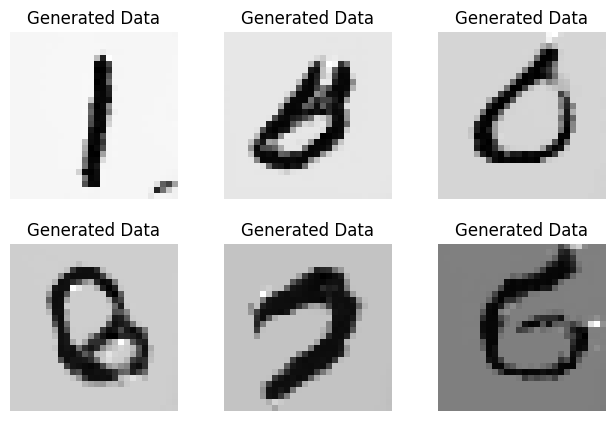

epoch  151


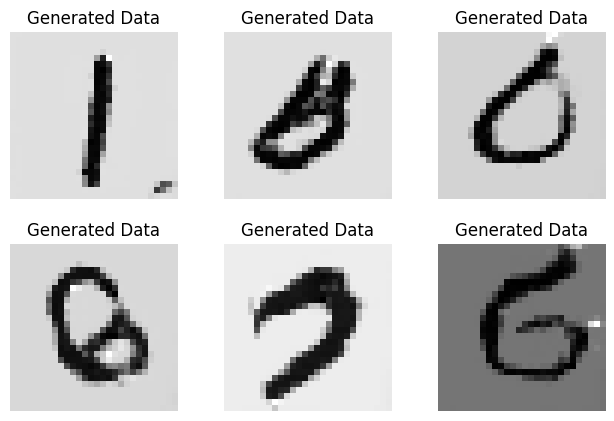

epoch  152


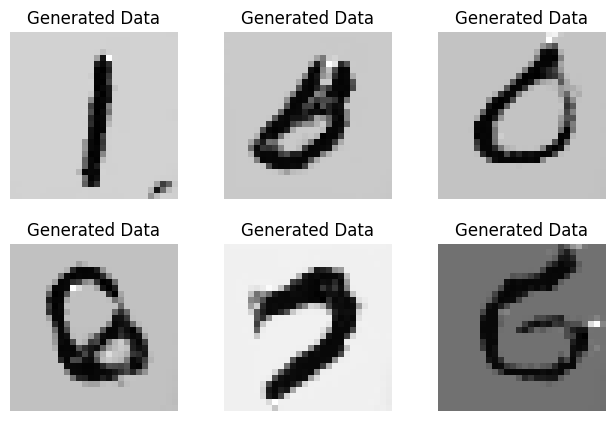

epoch  153


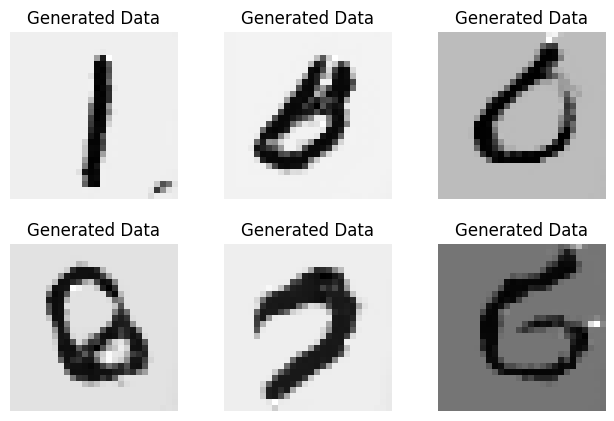

epoch  154


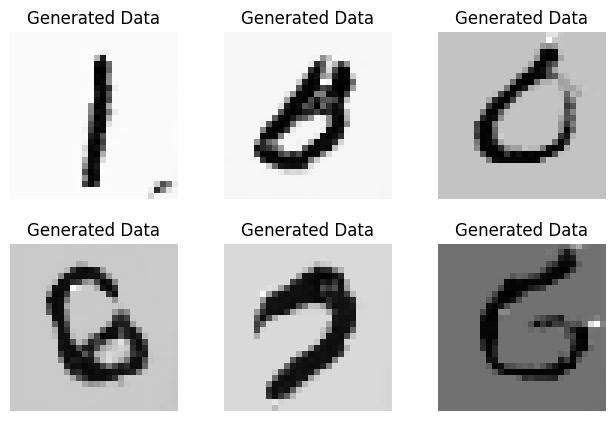

epoch  155


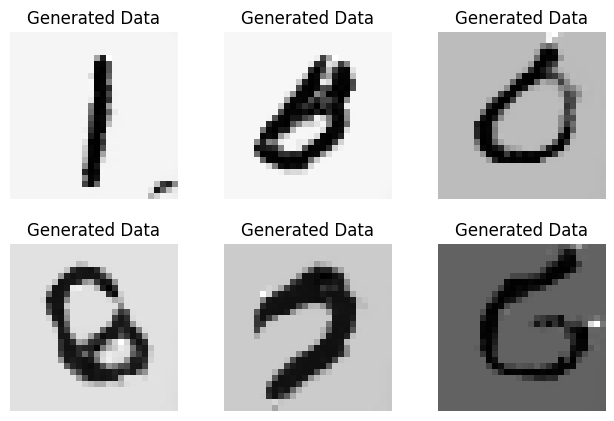

epoch  156


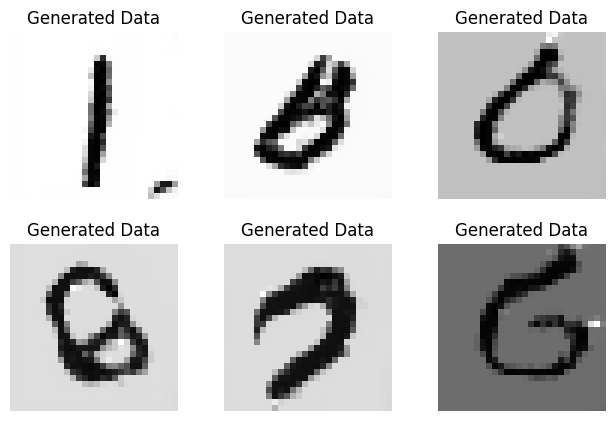

epoch  157


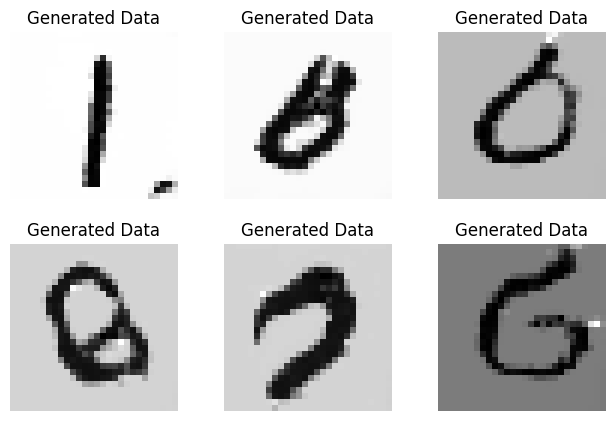

epoch  158


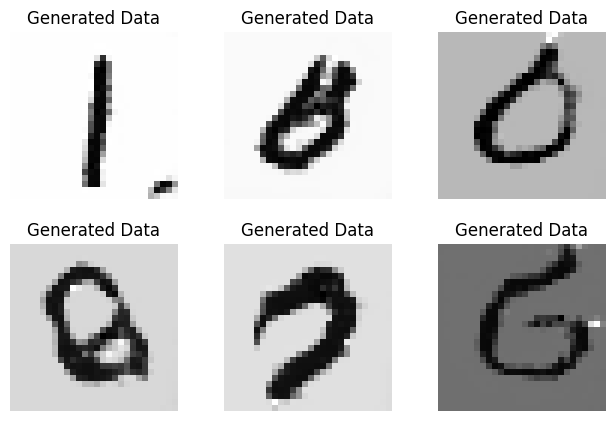

epoch  159


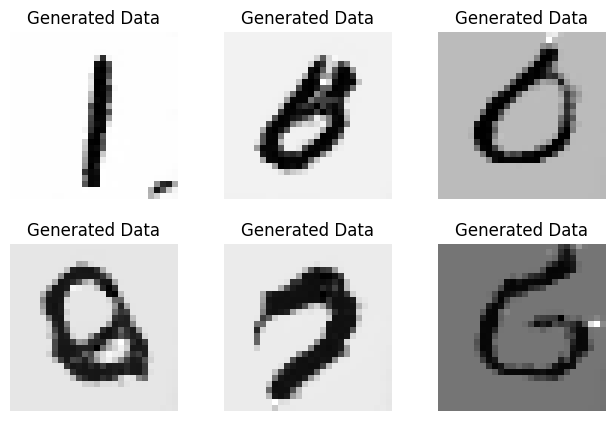

epoch  160


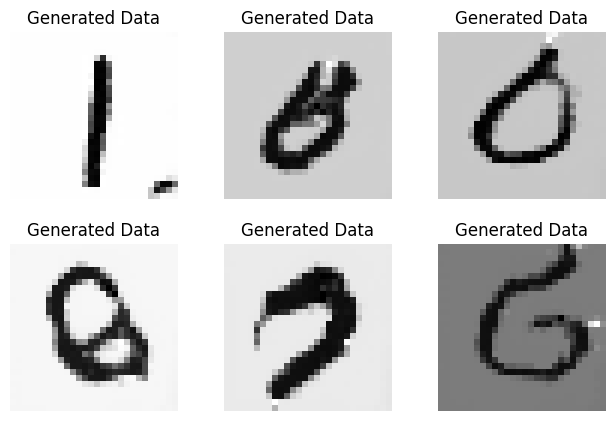

epoch  161


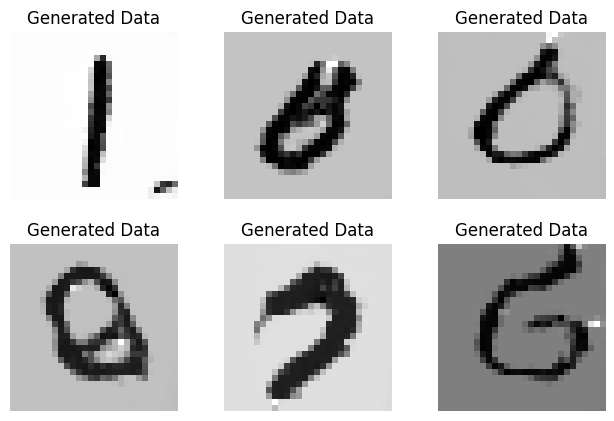

epoch  162


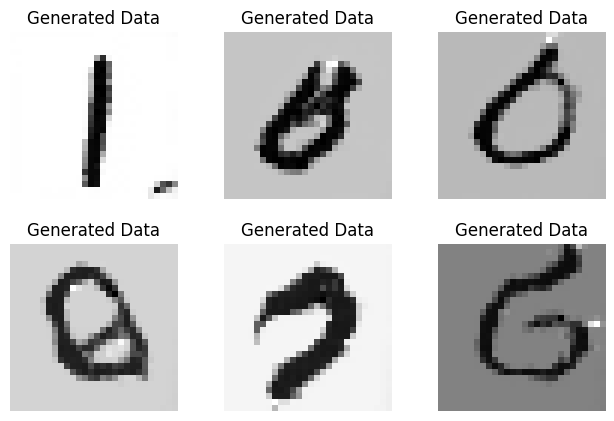

epoch  163


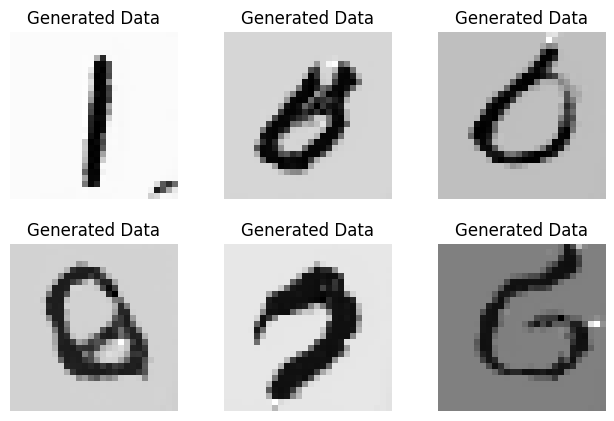

epoch  164


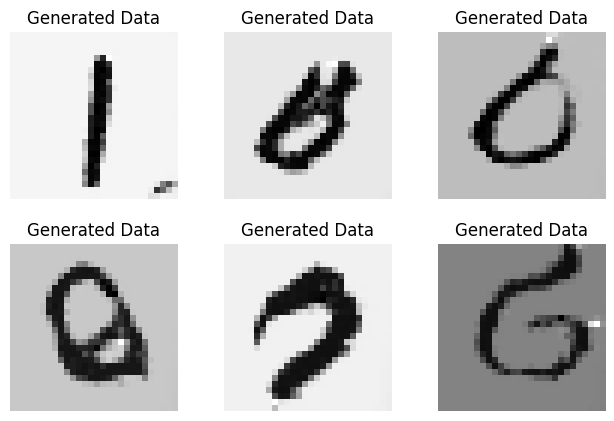

epoch  165


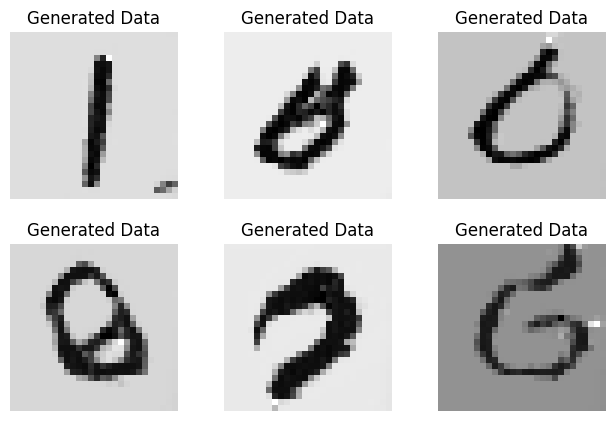

epoch  166


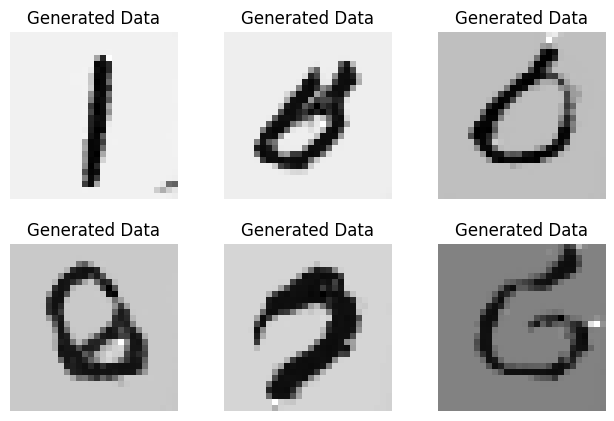

epoch  167


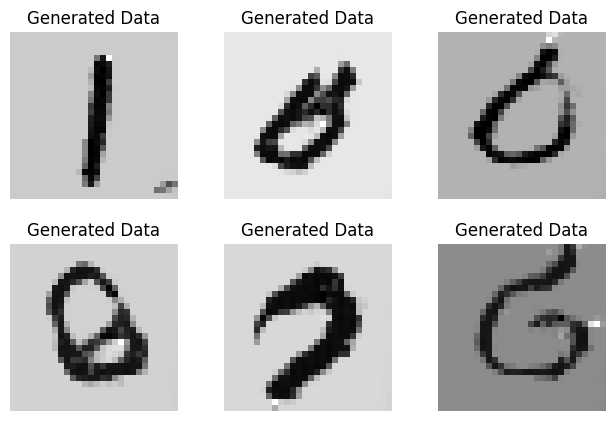

epoch  168


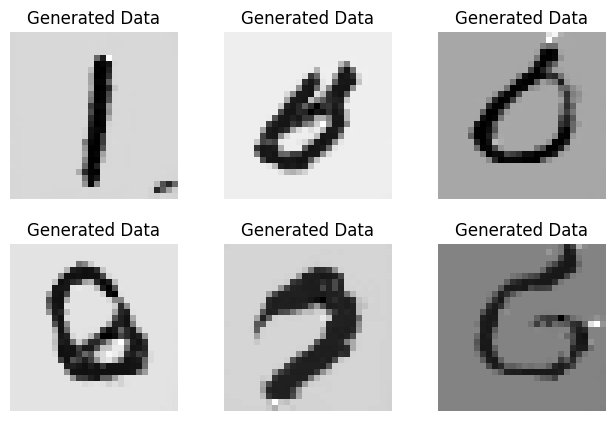

epoch  169


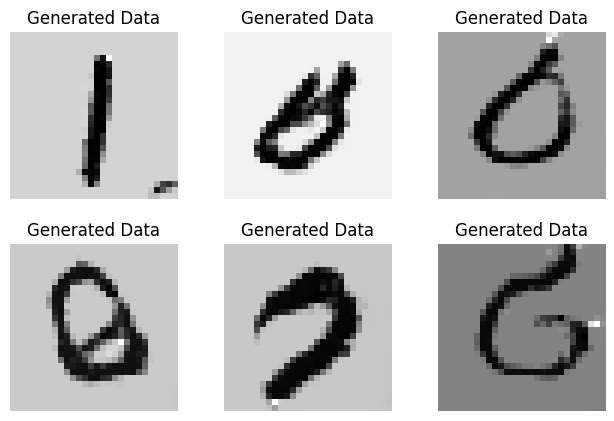

epoch  170


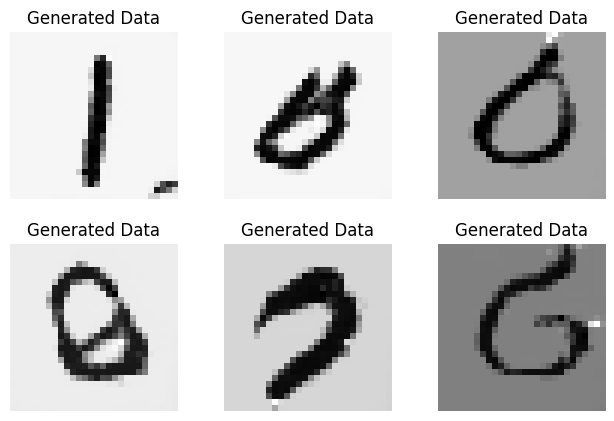

epoch  171


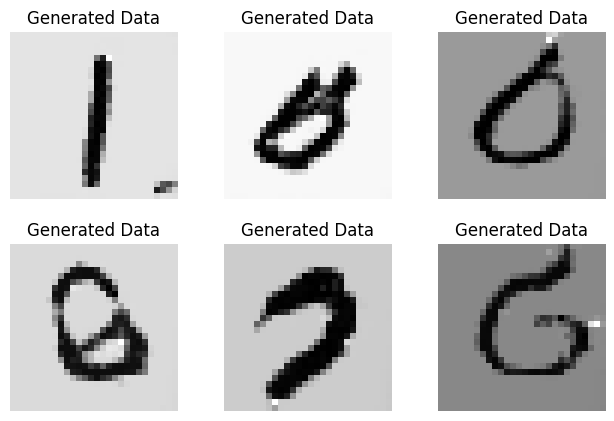

epoch  172


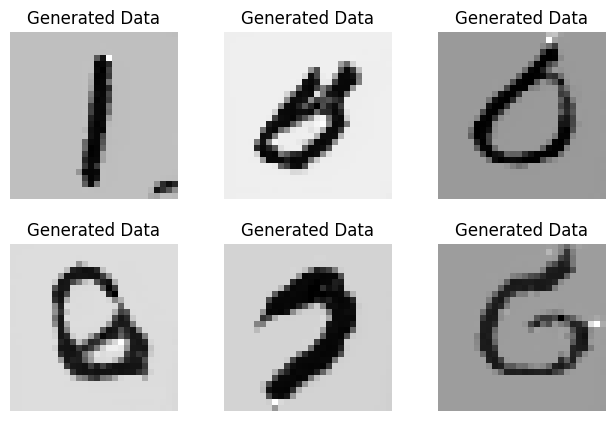

epoch  173


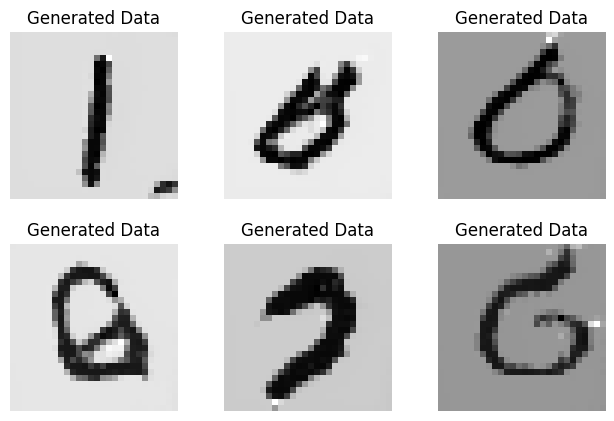

epoch  174


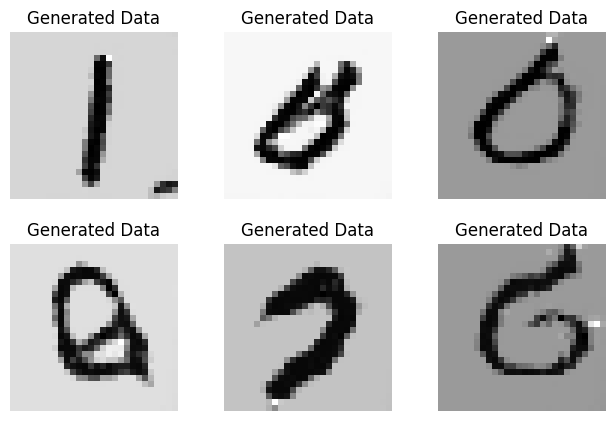

epoch  175


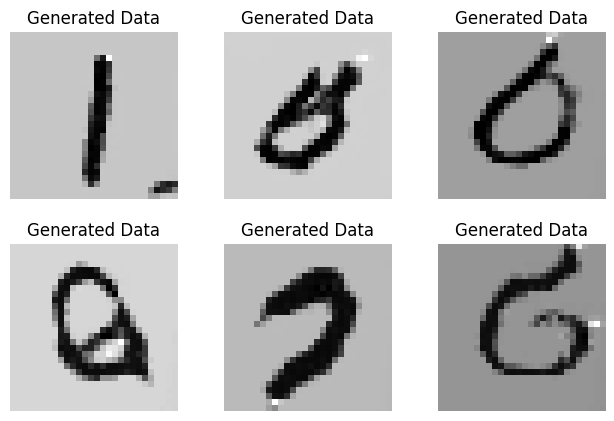

epoch  176


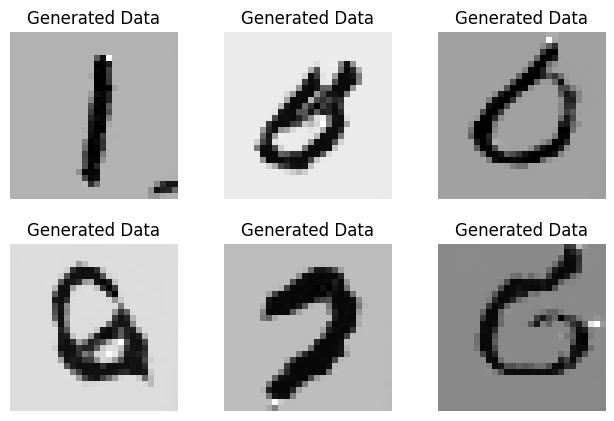

epoch  177


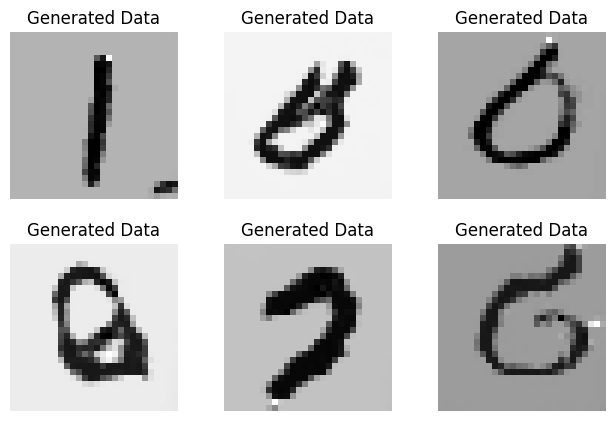

epoch  178


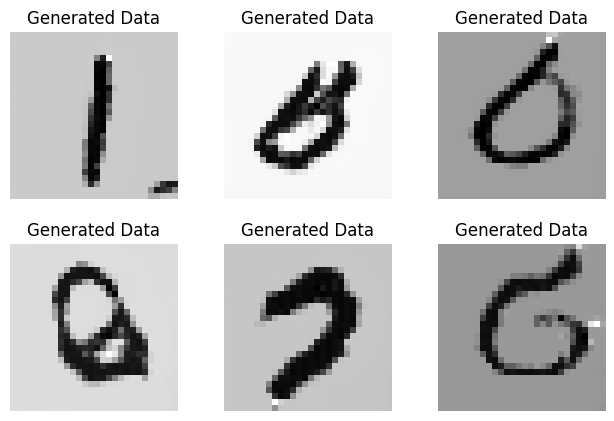

epoch  179


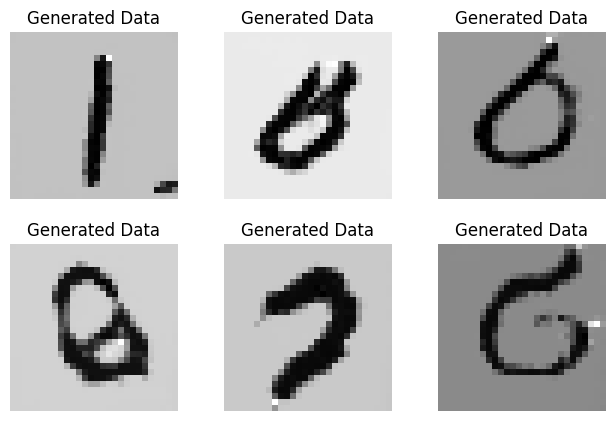

epoch  180


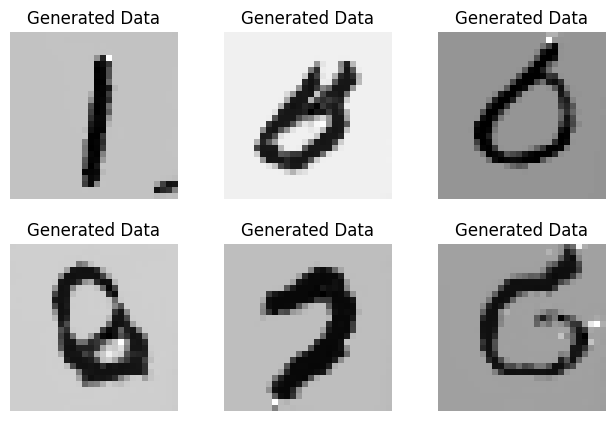

epoch  181


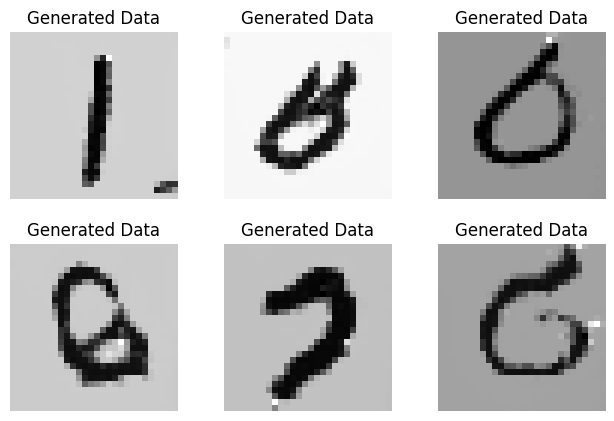

epoch  182


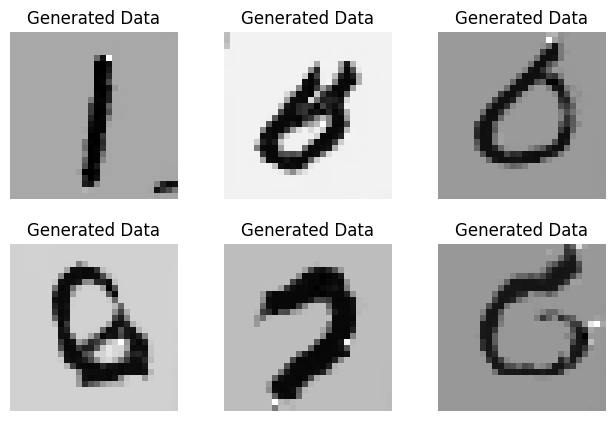

epoch  183


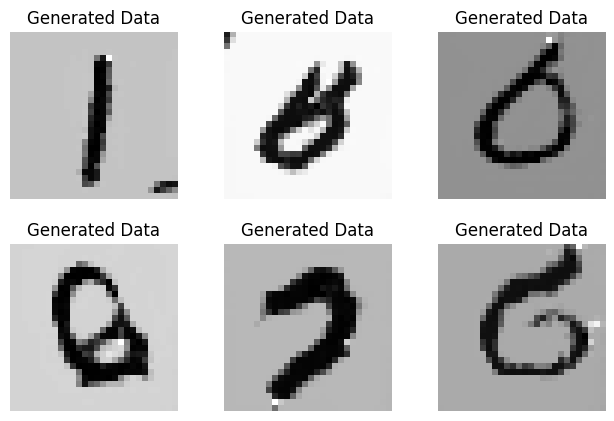

epoch  184


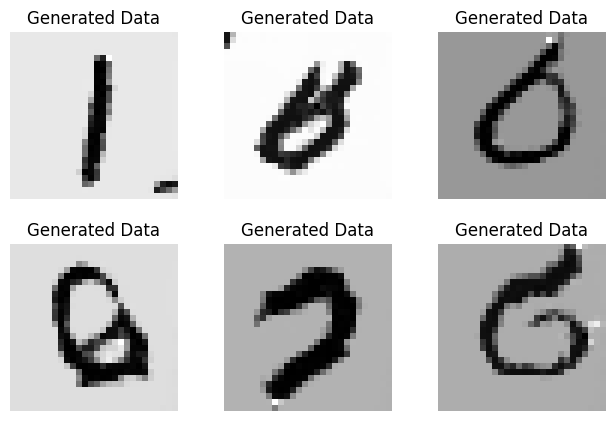

epoch  185


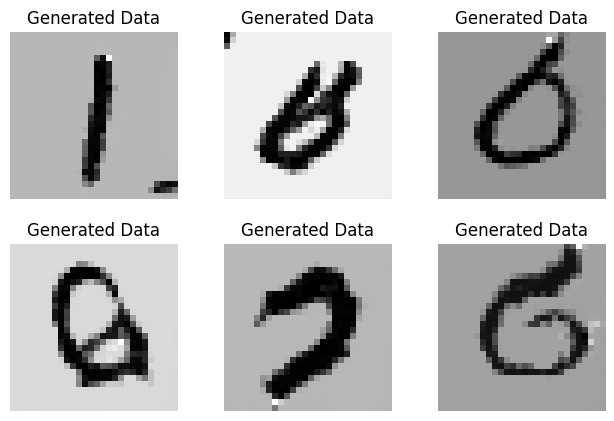

epoch  186


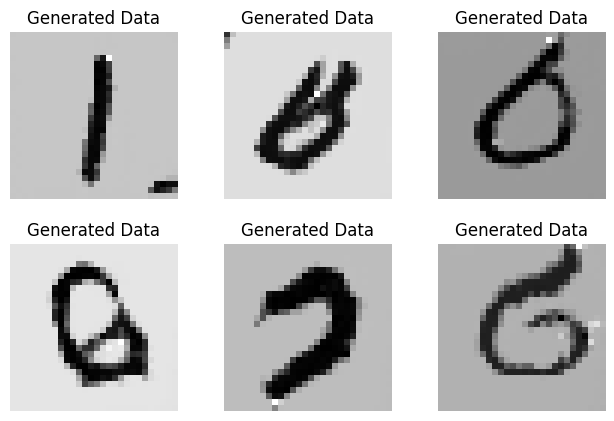

epoch  187


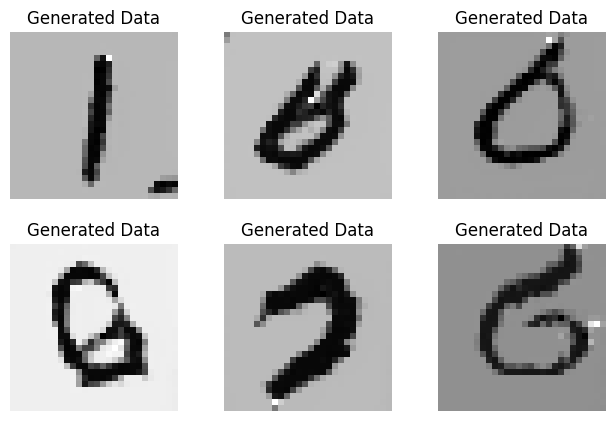

epoch  188


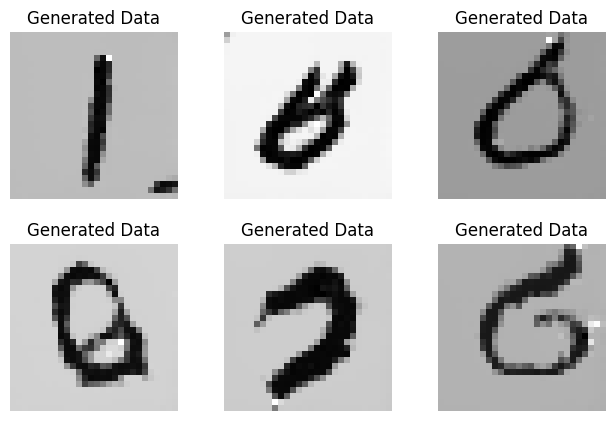

epoch  189


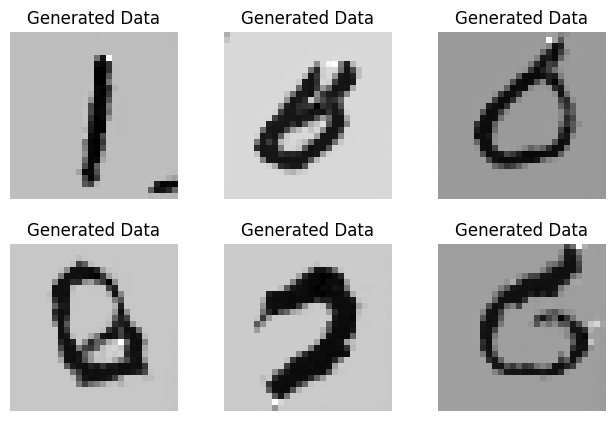

epoch  190


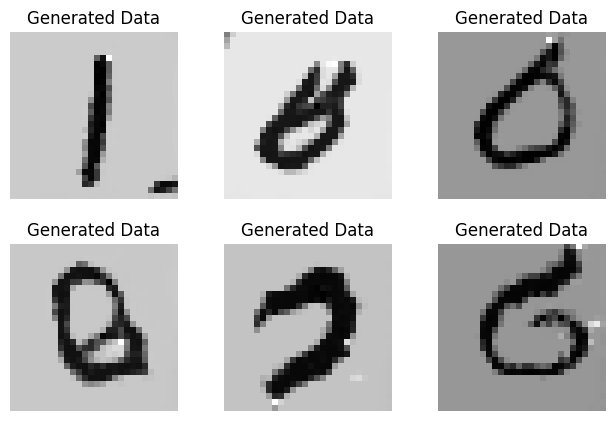

epoch  191


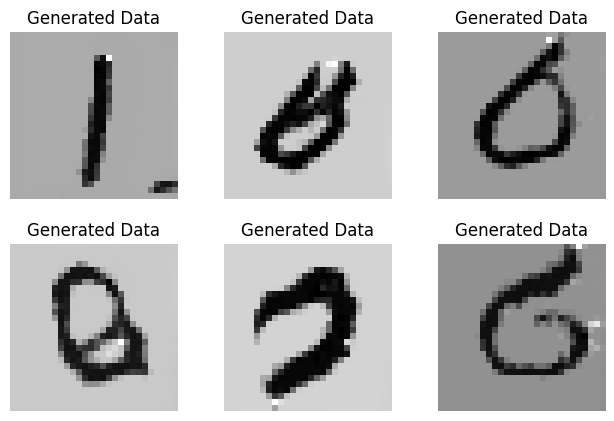

epoch  192


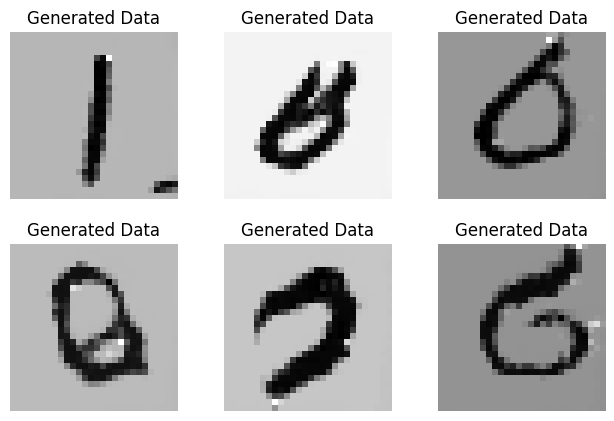

epoch  193


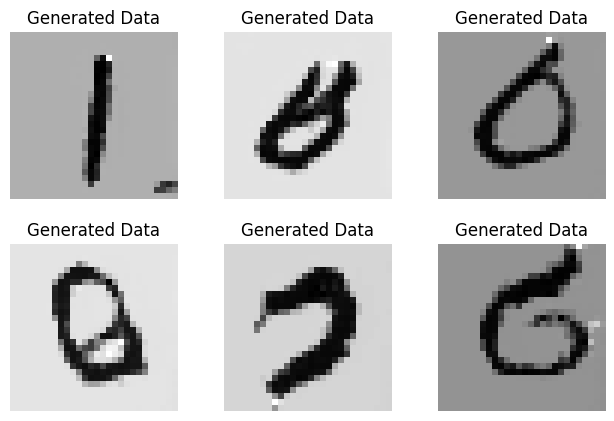

epoch  194


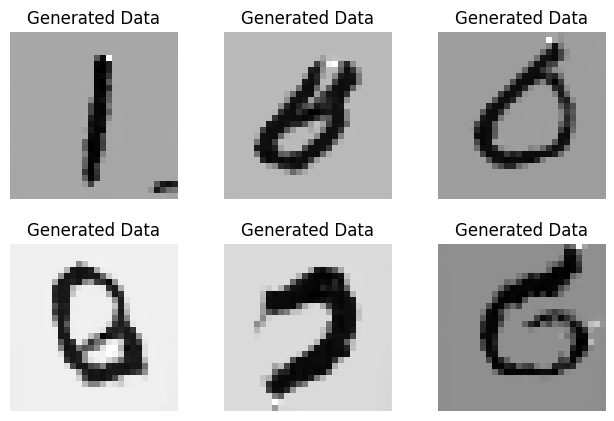

epoch  195


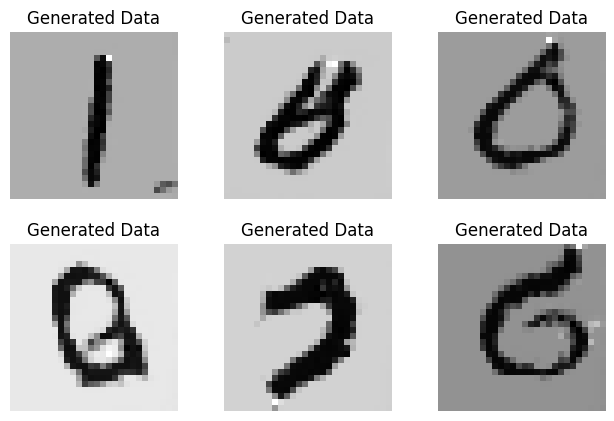

epoch  196


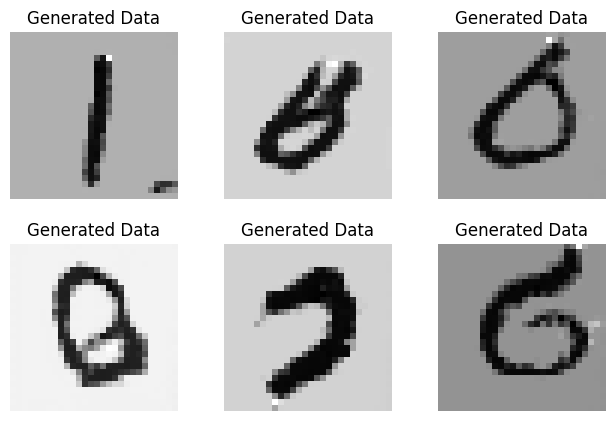

epoch  197


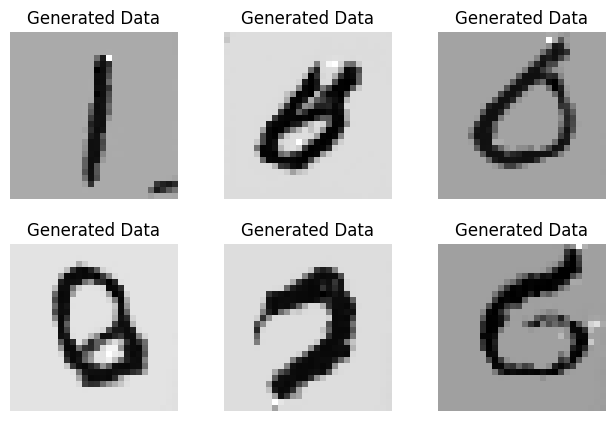

epoch  198


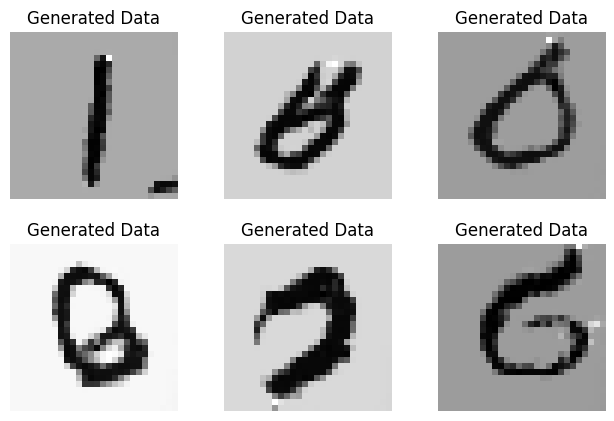

epoch  199


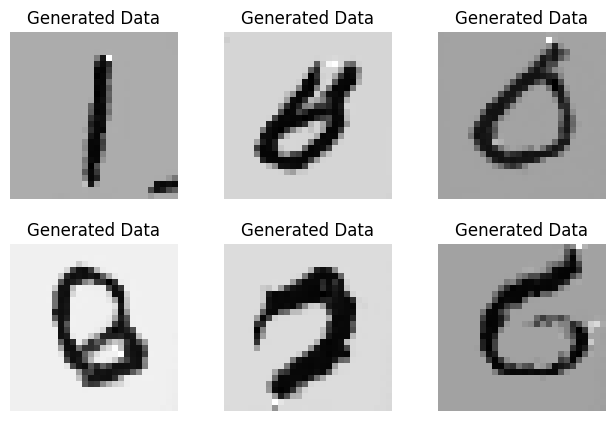

In [ ]:
trainer = pl.Trainer(max_epochs= 200, gpus= AVAIL_GPUS)
MNIST('./data', train=False, download=True)
trainer.fit(model2, dm)
trainer.save_checkpoint("/content/drive/MyDrive/Saved_Models/GAN/GAN1.ckpt")

Some testing for saving Images

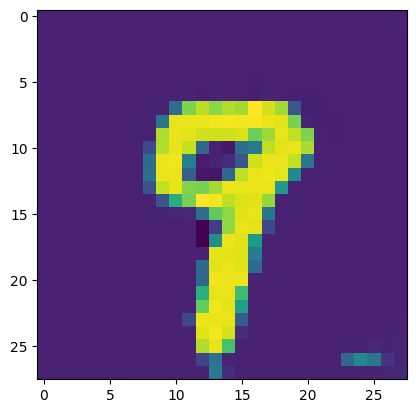

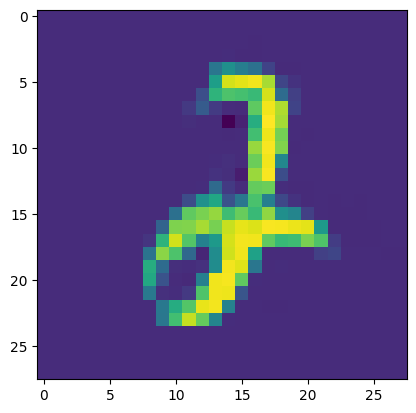

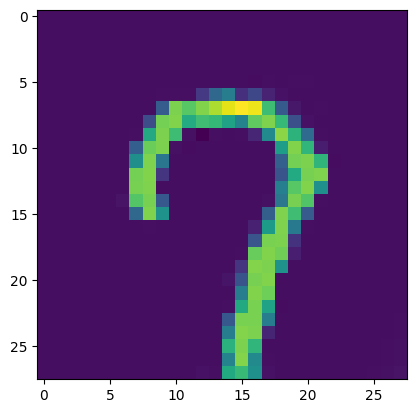

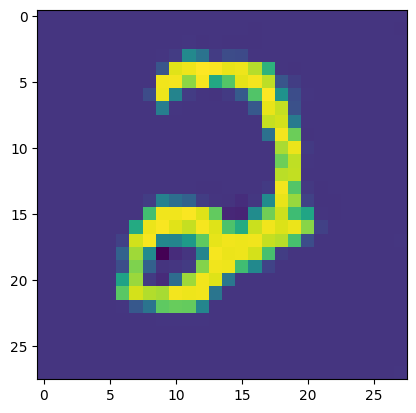

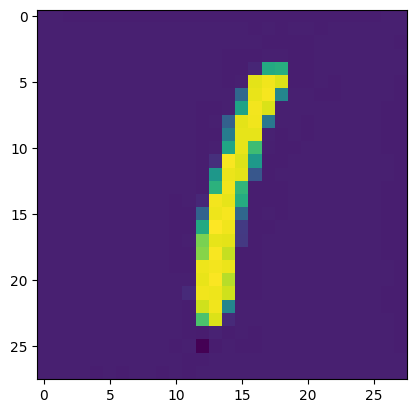

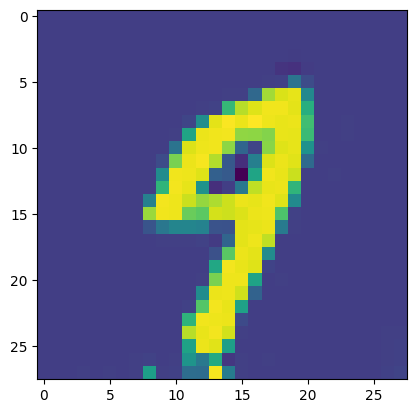

In [ ]:
import os.path
from os import path

TRANSFORM = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
mnist_val = MNIST("./data", train=False, download=True, transform=TRANSFORM)
for batch in DataLoader(mnist_val, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
  img, _ = batch
  break
z = torch.randn(img.shape[0], 100)
z = z.type_as(img)
fake_imgs = model2(z)



if path.exists('/content/For_Download') == False:
  os.mkdir('/content/For_Download')

for i in range(fake_imgs.size(0)):
  fig = plt.figure()
  # plt.subplot(2, 3, i + 1)
  # plt.tight_layout()
  plt.imshow(fake_imgs.detach()[i, 0, :, :], interpolation = 'none')
  if i == 5:
    break
  plt.savefig(f"/content/For_Download/Img{i}.png")

<Figure size 640x480 with 0 Axes>